# About Dataset

### The data is acquired from 3 sources:

#### 1. cycling.data.tfl.gov.uk/ 'Contains OS data © Crown copyright and database rights 2016' and Geomni UK Map data © and database rights [2019] 'Powered by TfL Open Data'  
#### 2. freemeteo.com - weather data  
#### 3. www.gov.uk/bank-holidays (From 1/1/2015 to 31/12/2016)  
#### The data from cycling dataset is grouped by "Start time", this represent the count of new bike shares grouped by hour. The long duration shares are not taken in the count.

## Variables : 
- "timestamp" - timestamp field for grouping the data
- "cnt" - the count of a new bike shares
- "t1" - real temperature in C
- "t2" - temperature in C "feels like"
- "hum" - humidity in percentage
- "windspeed" - wind speed in km/h
- "weathercode" - category of the weather
- "isholiday" - boolean field - __1__ holiday / __0__ non holiday
- "isweekend" - boolean field - __1__ if the day is weekend
- "season" - category field meteorological seasons: __0__-spring ; __1__-summer; __2__-fall; __3__-winter.

  __"weathe_code"__ category description:  
    - __1__ = Clear, mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity   
    - __2__ = scattered clouds / few clouds     
    - __3__ = Broken clouds   
    - __4__ = Cloudy   
    - __7__ = Rain/ light Rain shower/ Light rain   
    - __10__ = rain with thunderstorm   
    - __26__ = snowfall   
    - __94__ = Freezing Fog

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, boxcox
from scipy import stats
import scipy as scp
import warnings
warnings.filterwarnings('ignore')
from collections import Counter

# Getting data

In [2]:
data = pd.read_csv('london_merged.csv')

# Intial Review

In [3]:
data.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [4]:
data.shape

(17414, 10)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


In [6]:
data.describe()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
count,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000
mean,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075
std,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911
min,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000
50%,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000
75%,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000
max,7860.000000,34.000000,34.000000,100.000000,56.500000,26.000000,1.000000,1.000000,3.000000


# Changing Column Names

In [7]:
data.rename(columns={'t1':'temp_c','t2':'temp_feels_like','hum':'humidity','cnt':'bike_shares','weather_code': 'Weather','is_holiday': 'Holiday','is_weekend':'Weekend','season':'Season'},inplace=True)

In [8]:
data.columns

Index(['timestamp', 'bike_shares', 'temp_c', 'temp_feels_like', 'humidity',
       'wind_speed', 'Weather', 'Holiday', 'Weekend', 'Season'],
      dtype='object')

# Adding some more relevant features

In [9]:
data['timestamp'] = data['timestamp'].astype('datetime64')

In [10]:
data['hour'] = data.timestamp.dt.hour

In [11]:
data['day'] = data.timestamp.dt.day

In [12]:
data['day_of_week'] = data.timestamp.dt.dayofweek

In [13]:
data['month'] = data['timestamp'].dt.month

In [14]:
data['year'] = data.timestamp.dt.year

In [15]:
data.head()

,timestamp,bike_shares,temp_c,temp_feels_like,humidity,wind_speed,Weather,Holiday,Weekend,Season,hour,day,day_of_week,month,year
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,4,6,1,2015
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,4,6,1,2015
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,4,6,1,2015
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,4,6,1,2015
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,4,6,1,2015


# Checking Missing Values

In [16]:
data.isnull().sum()

timestamp          0
bike_shares        0
temp_c             0
temp_feels_like    0
humidity           0
wind_speed         0
Weather            0
Holiday            0
Weekend            0
Season             0
hour               0
day                0
day_of_week        0
month              0
year               0
dtype: int64

<AxesSubplot:>

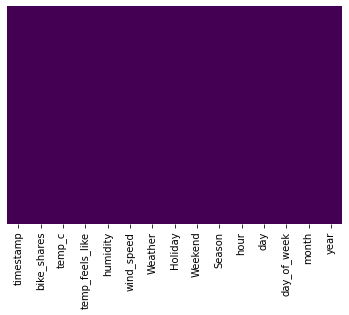

In [17]:
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

## No missing values found !

# Checking duplicate values

In [18]:
data.duplicated().sum()

0

## No duplicate values found !

# Checking distribution of data

array([[<AxesSubplot:title={'center':'timestamp'}>,
        <AxesSubplot:title={'center':'bike_shares'}>,
        <AxesSubplot:title={'center':'temp_c'}>,
        <AxesSubplot:title={'center':'temp_feels_like'}>],
       [<AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'wind_speed'}>,
        <AxesSubplot:title={'center':'Weather'}>,
        <AxesSubplot:title={'center':'Holiday'}>],
       [<AxesSubplot:title={'center':'Weekend'}>,
        <AxesSubplot:title={'center':'Season'}>,
        <AxesSubplot:title={'center':'hour'}>,
        <AxesSubplot:title={'center':'day'}>],
       [<AxesSubplot:title={'center':'day_of_week'}>,
        <AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':'year'}>, <AxesSubplot:>]],
      dtype=object)

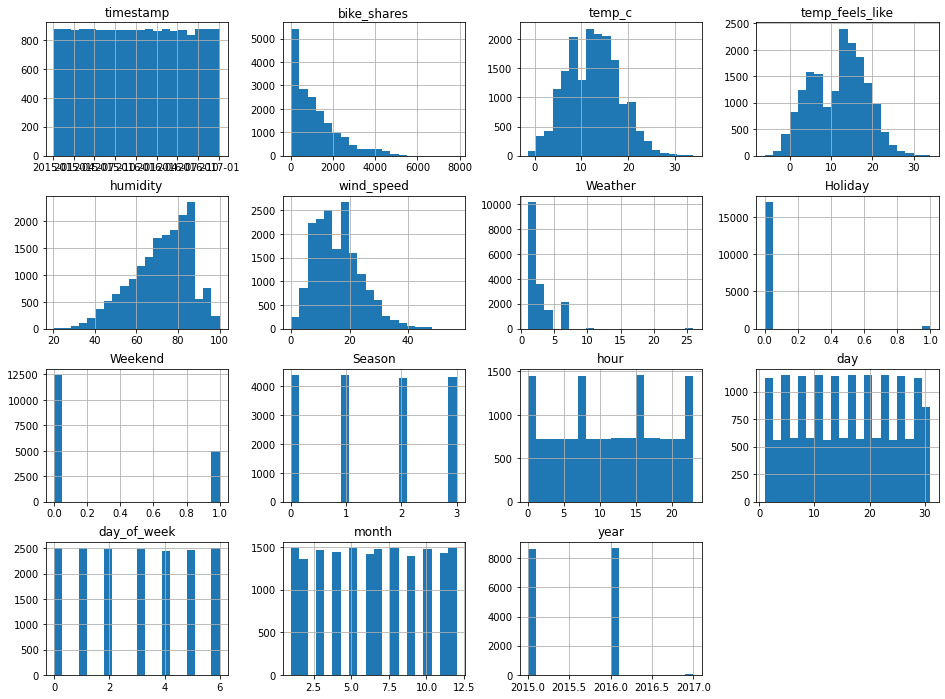

In [19]:
data.hist(bins=20, figsize=(16,12))

# Exploring Categorical Features

In [20]:
data.Holiday.value_counts()

0.0    17030
1.0      384
Name: Holiday, dtype: int64

In [21]:
data.Weekend.value_counts()

0.0    12444
1.0     4970
Name: Weekend, dtype: int64

In [22]:
data.Weather.value_counts()

1.0     6150
2.0     4034
3.0     3551
7.0     2141
4.0     1464
26.0      60
10.0      14
Name: Weather, dtype: int64

In [23]:
data.Season.value_counts()

0.0    4394
1.0    4387
3.0    4330
2.0    4303
Name: Season, dtype: int64

In [24]:
data.day_of_week.value_counts()

0    2508
6    2505
1    2505
3    2492
2    2489
5    2465
4    2450
Name: day_of_week, dtype: int64

### function to visualize distribution of categorical data

In [25]:
def cat_feat(col_data):
    fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,5))
    fig.suptitle(col_data.name+' wise bike_shares',fontsize=15)
    sns.countplot(col_data,ax=ax[0])
    col_data.value_counts().plot.pie(autopct='%1.1f%%',ax=ax[1], shadow = True)
    plt.tight_layout()

In [26]:
data.columns

Index(['timestamp', 'bike_shares', 'temp_c', 'temp_feels_like', 'humidity',
       'wind_speed', 'Weather', 'Holiday', 'Weekend', 'Season', 'hour', 'day',
       'day_of_week', 'month', 'year'],
      dtype='object')

In [27]:
cat_data = ['Weather','Holiday', 'Weekend', 'Season']

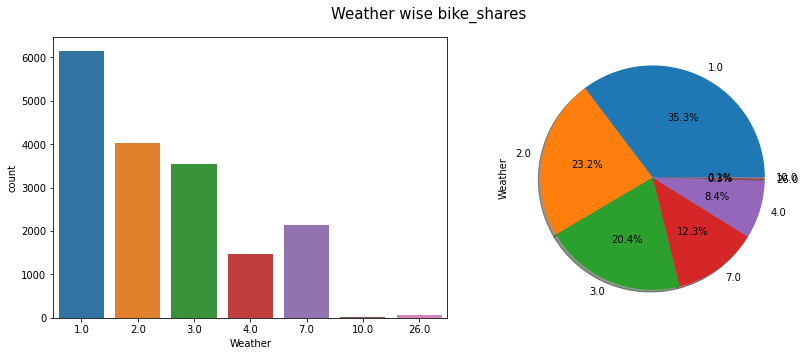

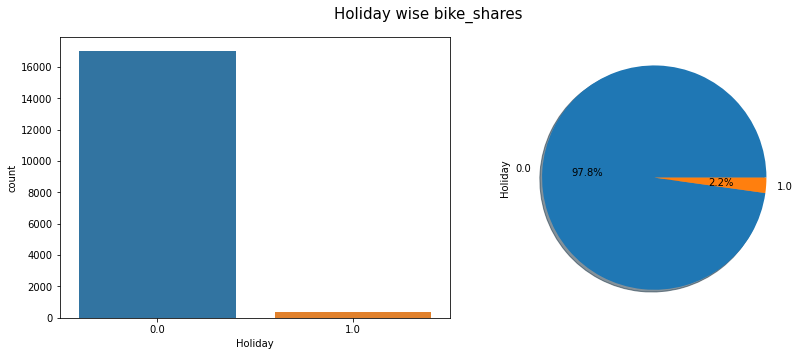

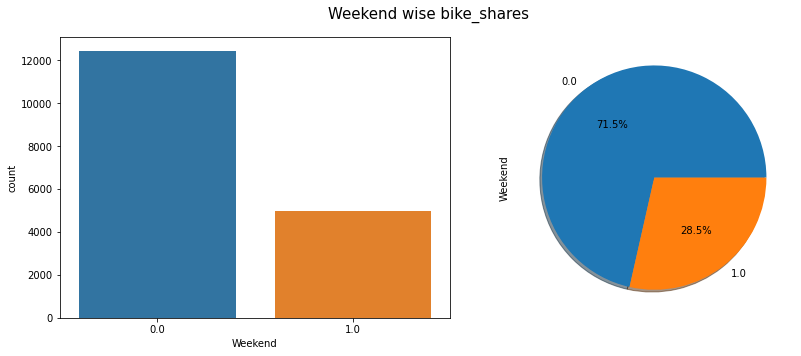

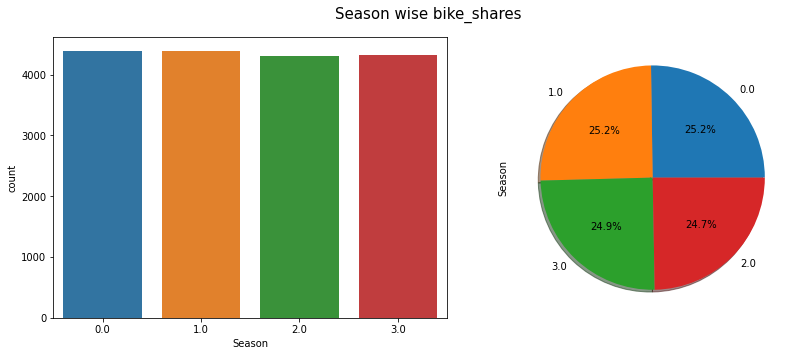

In [28]:
for i in cat_data:
    cat_feat(data[i])

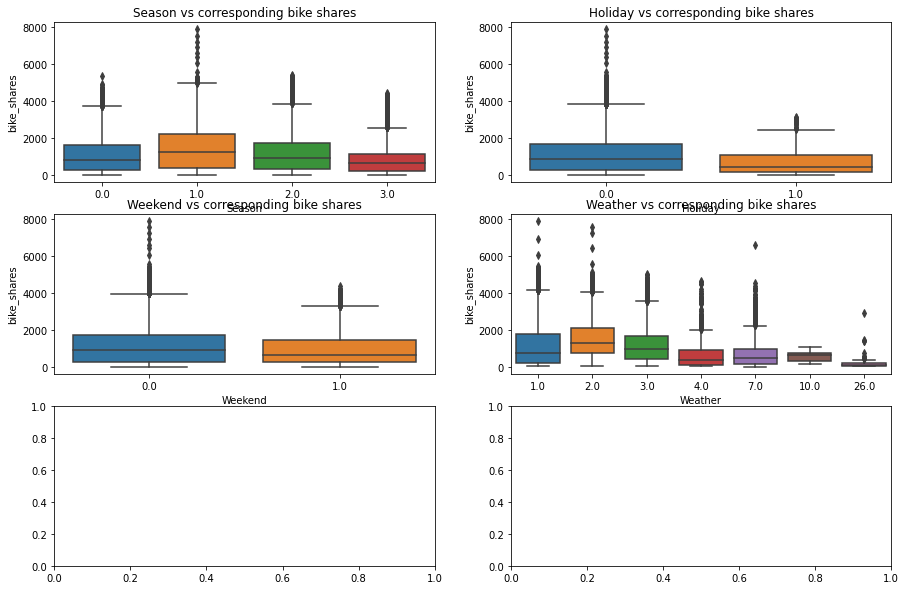

In [29]:
fig,ax = plt.subplots(3,2,figsize = (15,10))

sns.boxplot(x = 'Season', y = 'bike_shares', data = data,ax=ax[0,0])
ax[0,0].set_title('Season vs corresponding bike shares')

sns.boxplot(x = 'Holiday', y = 'bike_shares', data = data,ax=ax[0,1])
ax[0,1].set_title('Holiday vs corresponding bike shares')

sns.boxplot(x = 'Weekend', y = 'bike_shares', data = data,ax=ax[1,0])
ax[1,0].set_title('Weekend vs corresponding bike shares')

sns.boxplot(x = 'Weather', y = 'bike_shares', data = data,ax=ax[1,1])
ax[1,1].set_title('Weather vs corresponding bike shares')

plt.show()

## Function to visualize bike shares' trend in different time durations

In [30]:
def time_relation(time_period,count):
    temp_data = time_period+'data'
    temp_data = data.groupby([time_period])[count].sum().reset_index()
    sns.barplot(x=time_period,y=count,data=(temp_data))
    plt.title('Count of booking per '+time_period)
    plt.show()

In [31]:
temp_data=data.loc[:,['timestamp','bike_shares']]

In [32]:
temp_data

,timestamp,bike_shares
0,2015-01-04 00:00:00,182
1,2015-01-04 01:00:00,138
2,2015-01-04 02:00:00,134
3,2015-01-04 03:00:00,72
4,2015-01-04 04:00:00,47
...,...,...
17409,2017-01-03 19:00:00,1042
17410,2017-01-03 20:00:00,541
17411,2017-01-03 21:00:00,337
17412,2017-01-03 22:00:00,224


In [33]:
temp_data = temp_data.set_index("timestamp")

## No. of bike shares per hour

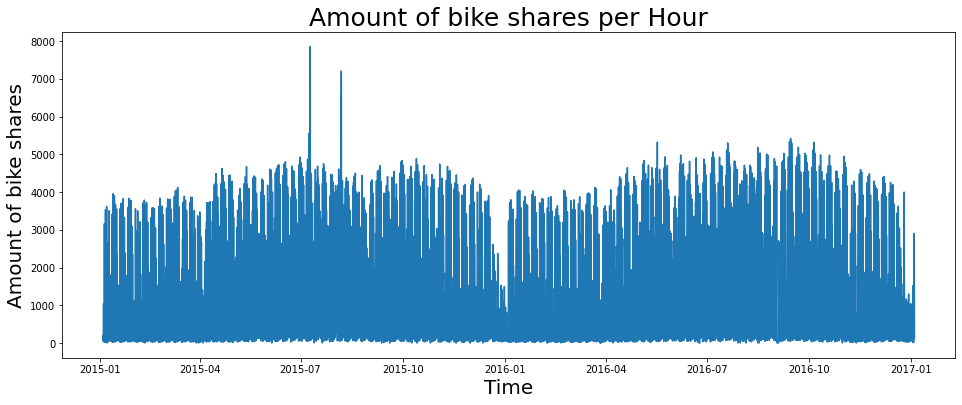

In [34]:
df_by_hour = temp_data.resample("H").sum()
plt.figure(figsize=(16,6))
ax = sns.lineplot(data=df_by_hour,x=df_by_hour.index,y=df_by_hour.bike_shares)
ax.set_title("Amount of bike shares per Hour", fontsize=25)
ax.set_xlabel("Time", fontsize=20)
ax.set_ylabel('Amount of bike shares', fontsize=20)
plt.show()

## No. of bike shares per hour in a day

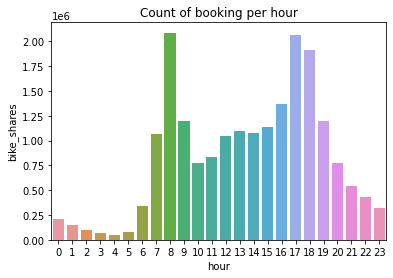

In [35]:
time_relation('hour','bike_shares')

## No. of bike shares per hour in a day, during holiday or normal day

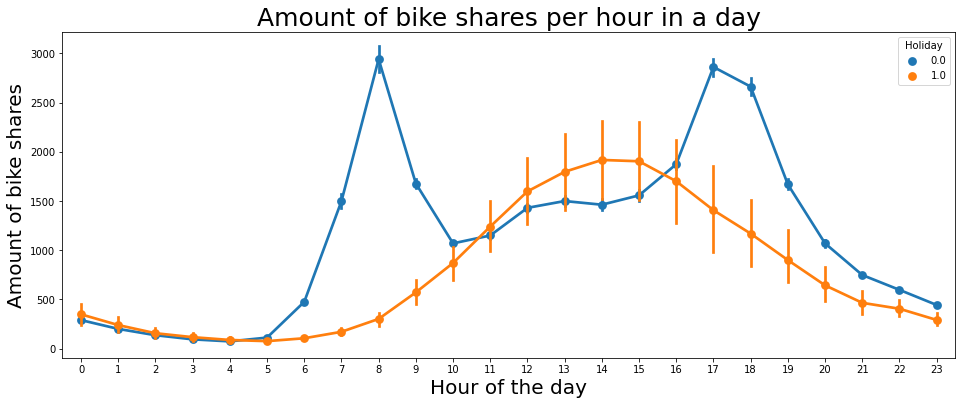

In [36]:
plt.figure(figsize=(16, 6))
ax = sns.pointplot(x='hour', y='bike_shares',hue='Holiday',data=data)
ax.set_title("Amount of bike shares per hour in a day", fontsize=25)
ax.set_xlabel("Hour of the day", fontsize=20)
ax.set_ylabel('Amount of bike shares', fontsize=20)
plt.show()

## No. of bike shares per hour on a weekend day

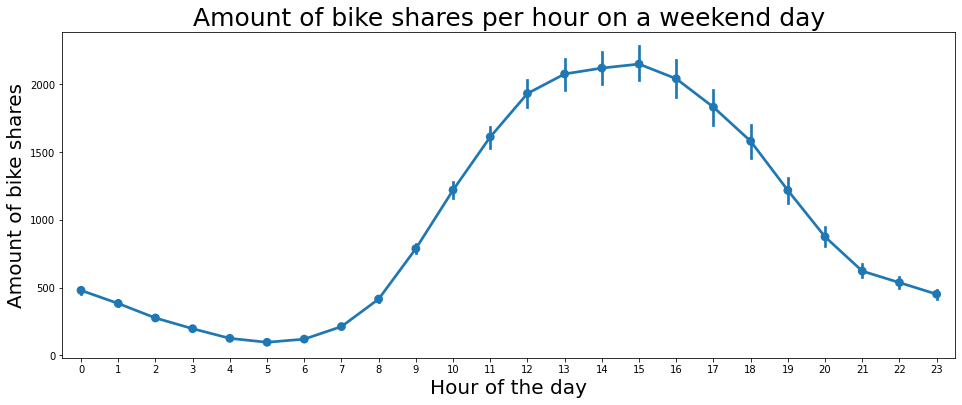

In [37]:
plt.figure(figsize=(16, 6))
ax = sns.pointplot(x='hour', y='bike_shares',data=data[data["Weekend"]==1])
ax.set_title("Amount of bike shares per hour on a weekend day", fontsize=25)
ax.set_xlabel("Hour of the day", fontsize=20)
ax.set_ylabel('Amount of bike shares', fontsize=20)
plt.show()

## No. of bike shares per hour on a week day

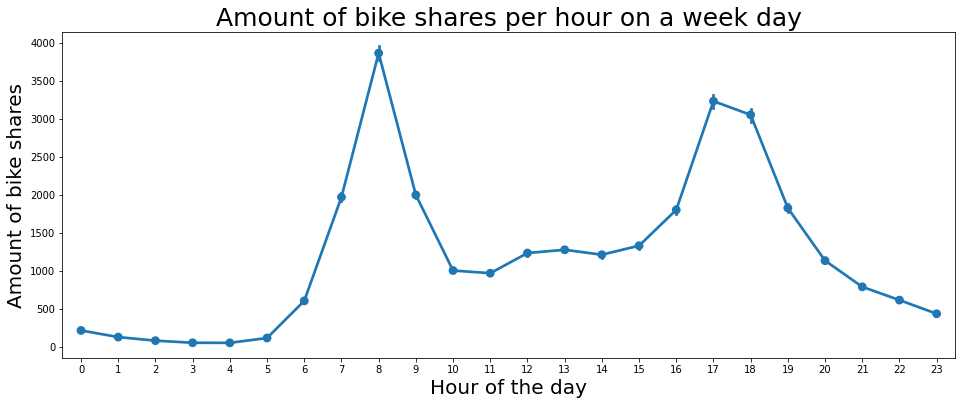

In [38]:
plt.figure(figsize=(16, 6))
ax = sns.pointplot(x='hour', y='bike_shares',data=data[data["Weekend"]==0])
ax.set_title("Amount of bike shares per hour on a week day", fontsize=25)
ax.set_xlabel("Hour of the day", fontsize=20)
ax.set_ylabel('Amount of bike shares', fontsize=20)
plt.show()

## No. of bike shares per day

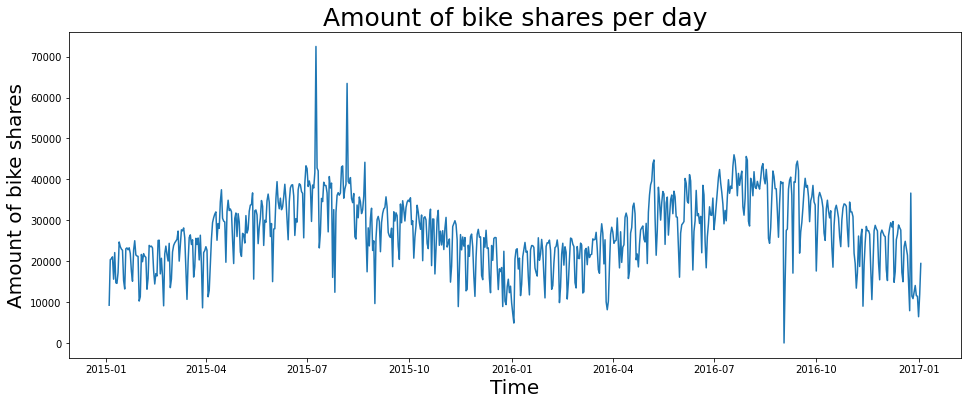

In [39]:
df_by_week = temp_data.resample("D").sum()
plt.figure(figsize=(16,6))
ax = sns.lineplot(data=df_by_week,x=df_by_week.index,y=df_by_week.bike_shares)
ax.set_title("Amount of bike shares per day", fontsize=25)
ax.set_xlabel("Time", fontsize=20)
ax.set_ylabel('Amount of bike shares', fontsize=20)
plt.show()

## No. of bike shares per day individually in a whole month

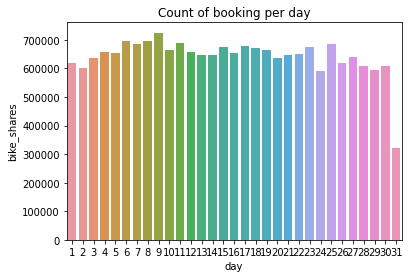

In [40]:
time_relation('day','bike_shares')

## No. of bike shares per week

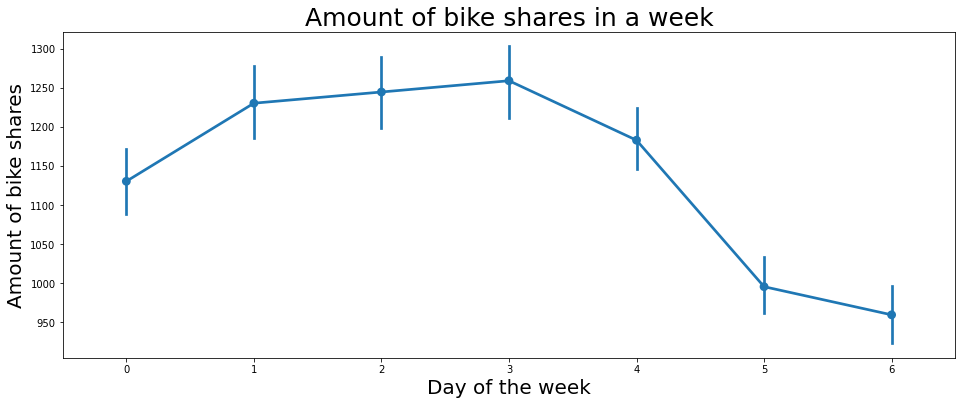

In [41]:
plt.figure(figsize=(16, 6))
ax = sns.pointplot(x='day_of_week', y='bike_shares',data=data)
ax.set_title("Amount of bike shares in a week", fontsize=25)
ax.set_xlabel("Day of the week", fontsize=20)
ax.set_ylabel('Amount of bike shares', fontsize=20)
plt.show()

## No. of bike shares per month

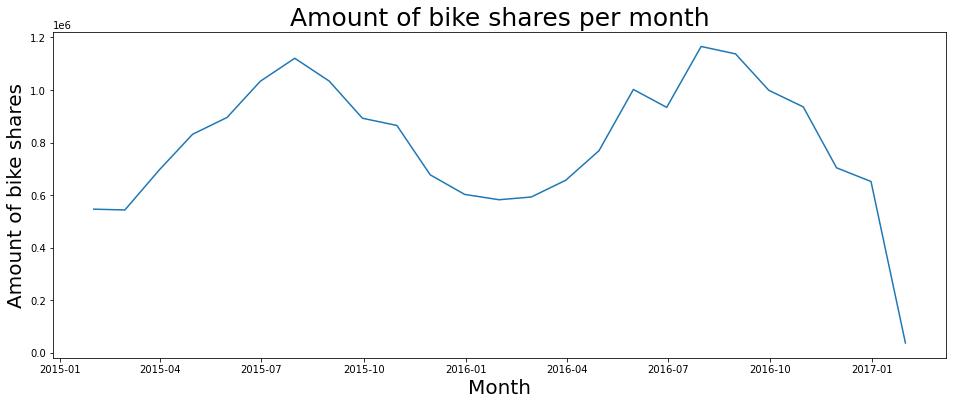

In [42]:
df_by_month = temp_data.resample("M").sum()

plt.figure(figsize=(16,6))
ax = sns.lineplot(data=df_by_month,x=df_by_month.index,y=df_by_month.bike_shares)
ax.set_title("Amount of bike shares per month", fontsize=25)
ax.set_xlabel("Month", fontsize=20)
ax.set_ylabel('Amount of bike shares', fontsize=20)
plt.show()

## No. of bike shares per month individually in a whole year

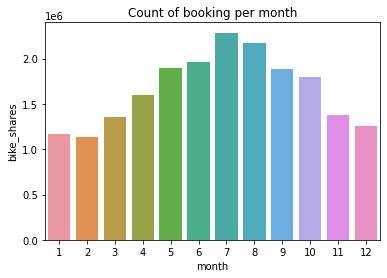

In [43]:
time_relation('month','bike_shares')

## No. of bike shares per season

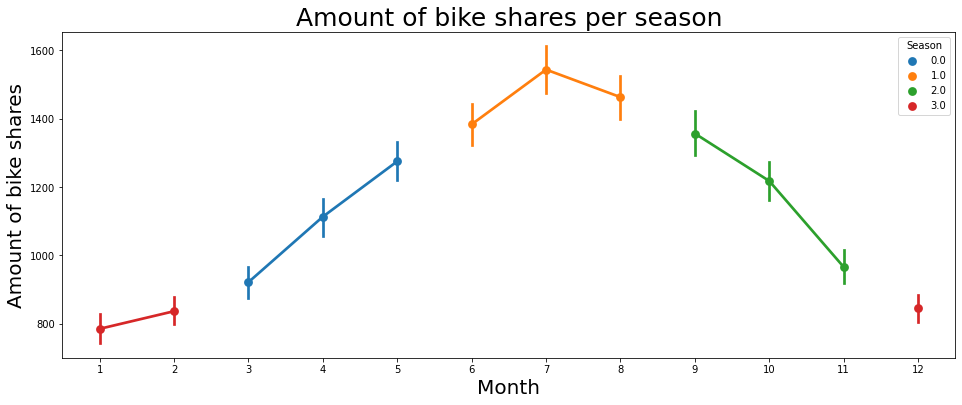

In [44]:
plt.figure(figsize=(16,6))
ax = sns.pointplot(data=data,hue=data.Season,y=data.bike_shares,x=data.month)
ax.set_title("Amount of bike shares per season", fontsize=25)
ax.set_xlabel("Month", fontsize=20)
ax.set_ylabel('Amount of bike shares', fontsize=20)
plt.show()

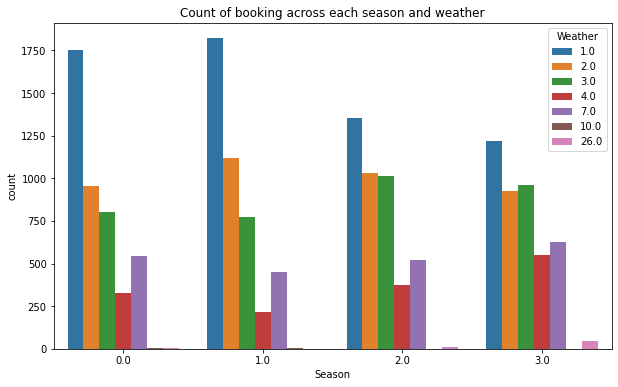

In [45]:
plt.figure(figsize=(10,6))
sns.countplot(x='Season',hue='Weather',data=data)
plt.title('Count of booking across each season and weather')
plt.show()

## No. of bike shares per year

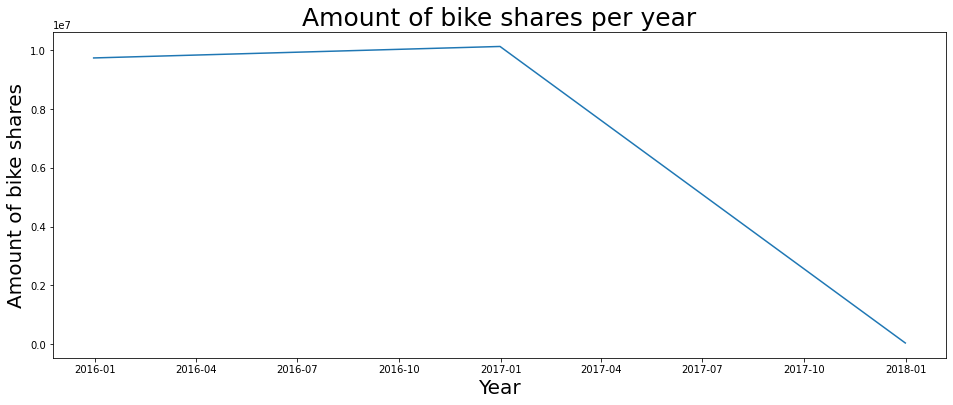

In [46]:
df_by_year = temp_data.resample("Y").sum()

plt.figure(figsize=(16,6))
ax = sns.lineplot(data=df_by_year,x=df_by_year.index,y=df_by_year.bike_shares)
ax.set_title("Amount of bike shares per year", fontsize=25)
ax.set_xlabel("Year", fontsize=20)
ax.set_ylabel('Amount of bike shares', fontsize=20)
plt.show()

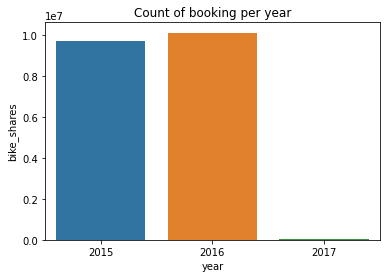

In [47]:
time_relation('year','bike_shares')

# Bivariate Analysis

In [48]:
colu = ['bike_shares', 'temp_c', 'temp_feels_like', 'humidity', 'wind_speed']

In [49]:
temp = data.loc[:,colu]

### Function to visualize relationship between No. of bike shares and various independent numerical features

In [50]:
def bivariate_analysis(x):
    plt.figure(figsize=(20,10))
    ax = sns.pointplot(x=x, y='bike_shares',data=data)
    ax.set_title("Amount of bike shares vs "+x, fontsize=25)
    ax.set_xlabel(x, fontsize=20)
    ax.set_ylabel('Amount of bike shares', fontsize=20)
    plt.locator_params(axis='x', nbins=10)

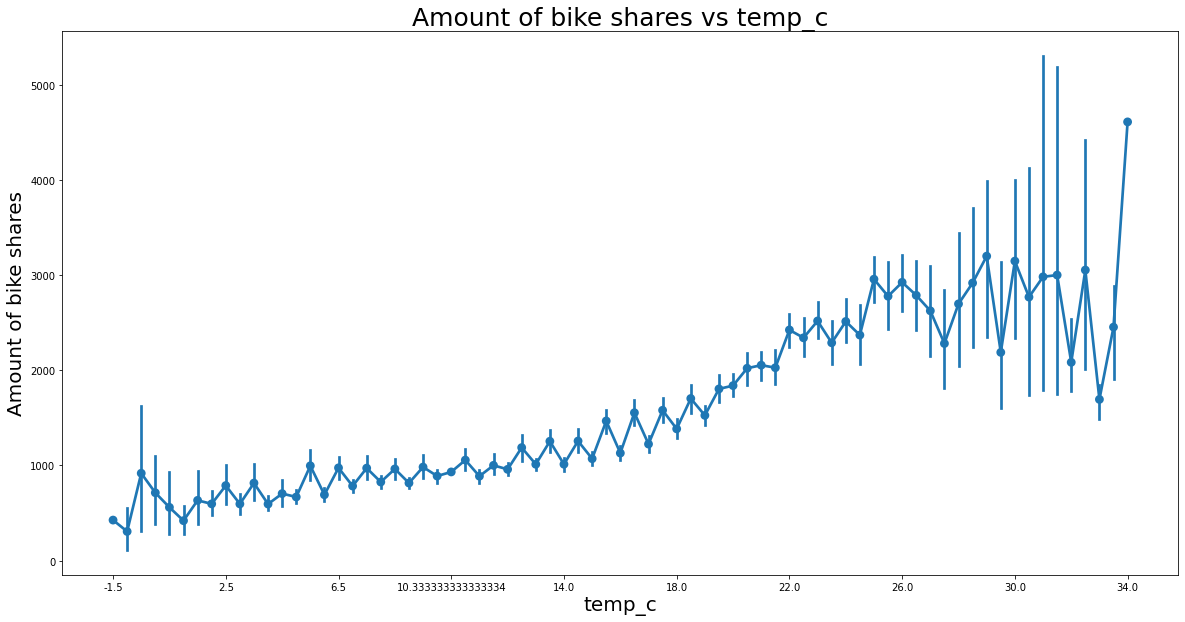

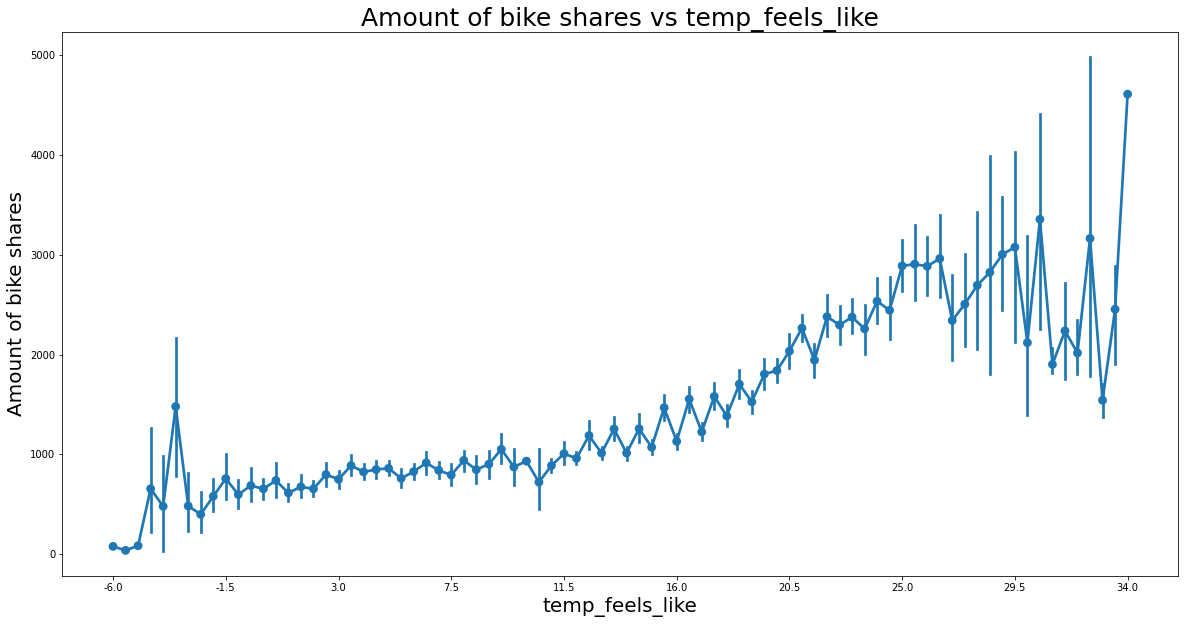

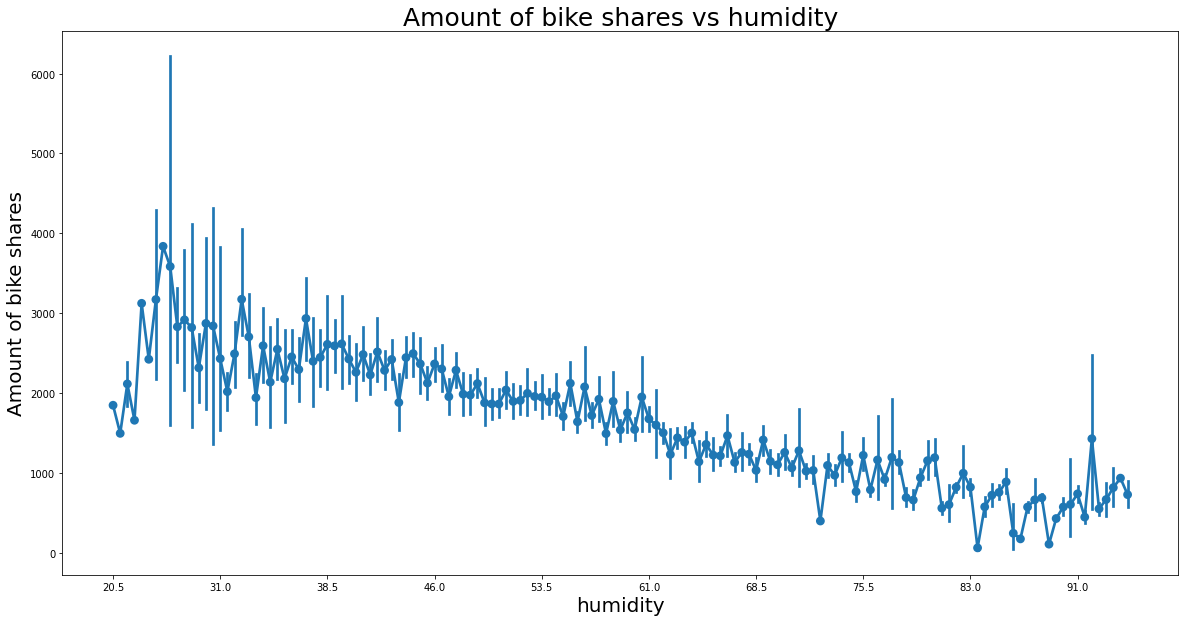

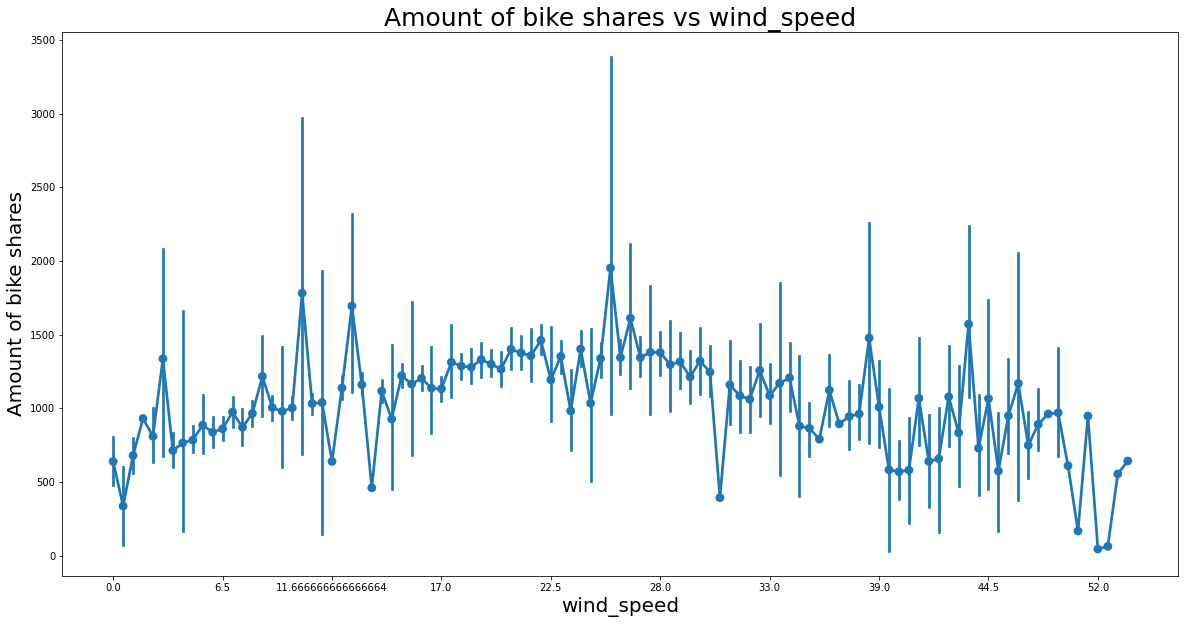

In [51]:
colu1 = ['temp_c', 'temp_feels_like', 'humidity', 'wind_speed']
for x in colu1:
    bivariate_analysis(x)

# Multivariate Analysis

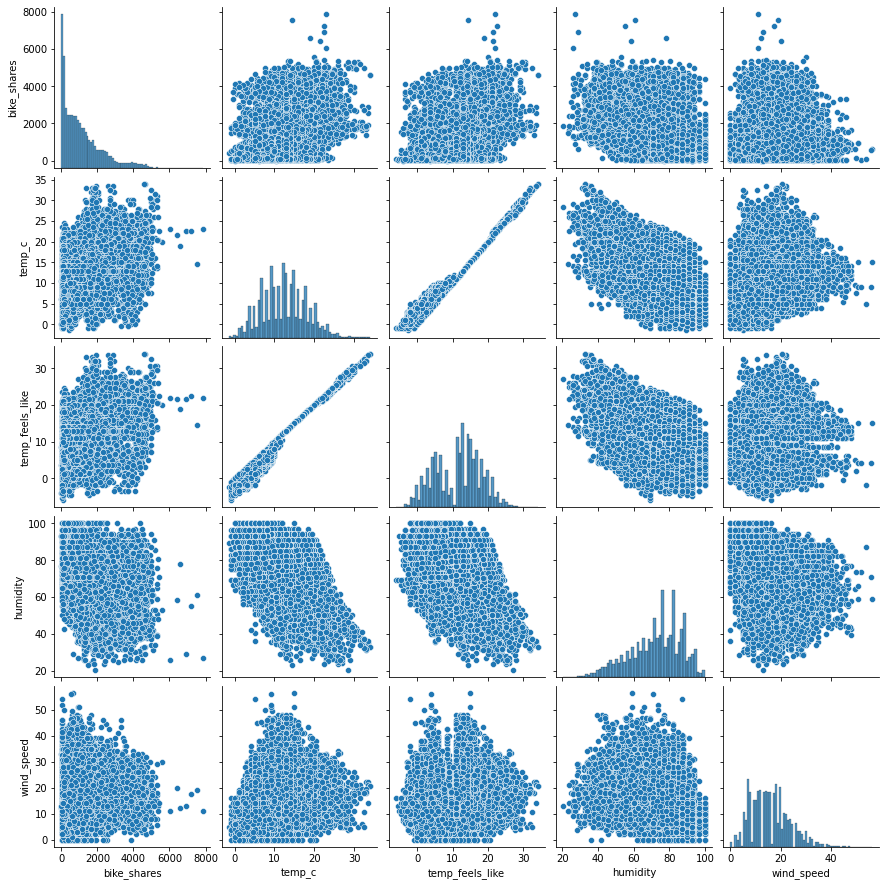

In [52]:
sns.pairplot(temp)

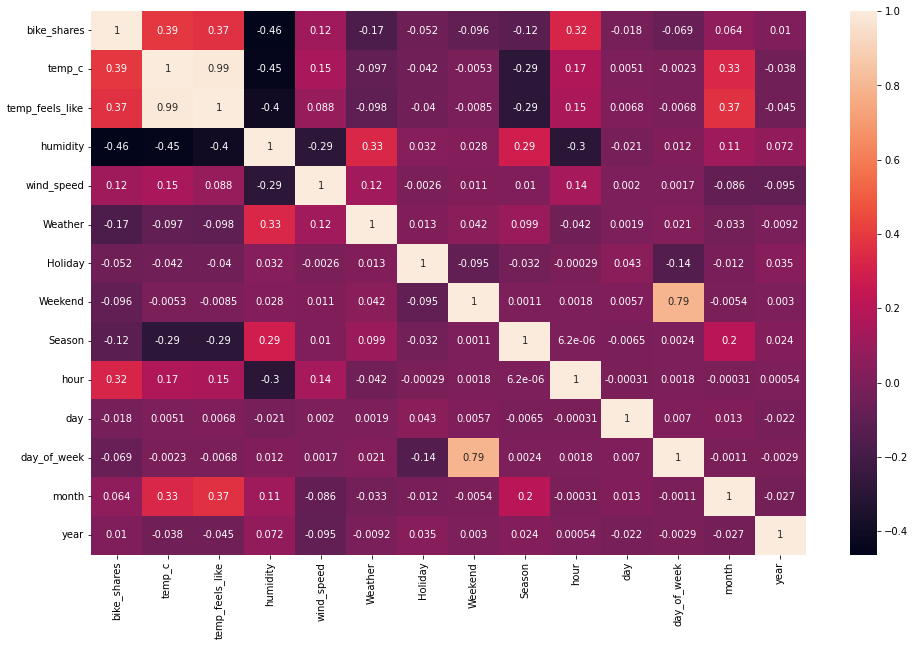

In [53]:
plt.figure(figsize = (16, 10))
sns.heatmap(data.corr(),annot=True)
plt.show()

# Relation between Features  
- __bike_shares__ has the highest <font color=green>__positive__</font> correlation with __temp_c__, followed by __temp_feels_like__,__hour__ and __wind_speed__.
- __bike_shares__ has the highest <font color=red>__negative__</font> correlation with __Humidity__ followed by __weather__ and __season__. 

### There is a <font color=green>__positive__</font> correlation between  
   -  __temp_c__ and __temp_feels_like__ __(HIGH)__    
   -  __month__ and __temp_feels_like__ __(MODERATE)__  
   -  __month__ and __temp_c__ __(MODERATE)__  
   -  __humidity__ and __season__ __(MODERATE)__  
   -  __weather__ and __Humidity__ __(MODERATE)__  
   -  __month__ and __season__ __(LOW)__  
   -  __weather__ and __wind_speed__ __(LOW)__  
   -  __month__ and __humidity__ __(LOW)__
   -  __hour__ and __temp_c__ __(LOW)__  
   -  __hour__ and __temp_feels_like__ __(LOW)__  
   -  __wind_speed__ and __temp_c__ __(LOW)__  

### There is a <font color=red>__negative__</font> correlation between  
   -  __temp_c__ and __Humidity__ __(HIGH)__  
   -  __temp_feels_like__ and __Humidity__ __(HIGH)__    
   -  __hour__ and __Humidity__ __(MODERATE)__  
   -  __wind_speed__ and __Humidity__ __(MODERATE)__  
   -  __season__ and __temp_c__ __(MODERATE)__  
   -  __season__ and __temp_feels_like __(MODERATE)__  

# Checking outliers

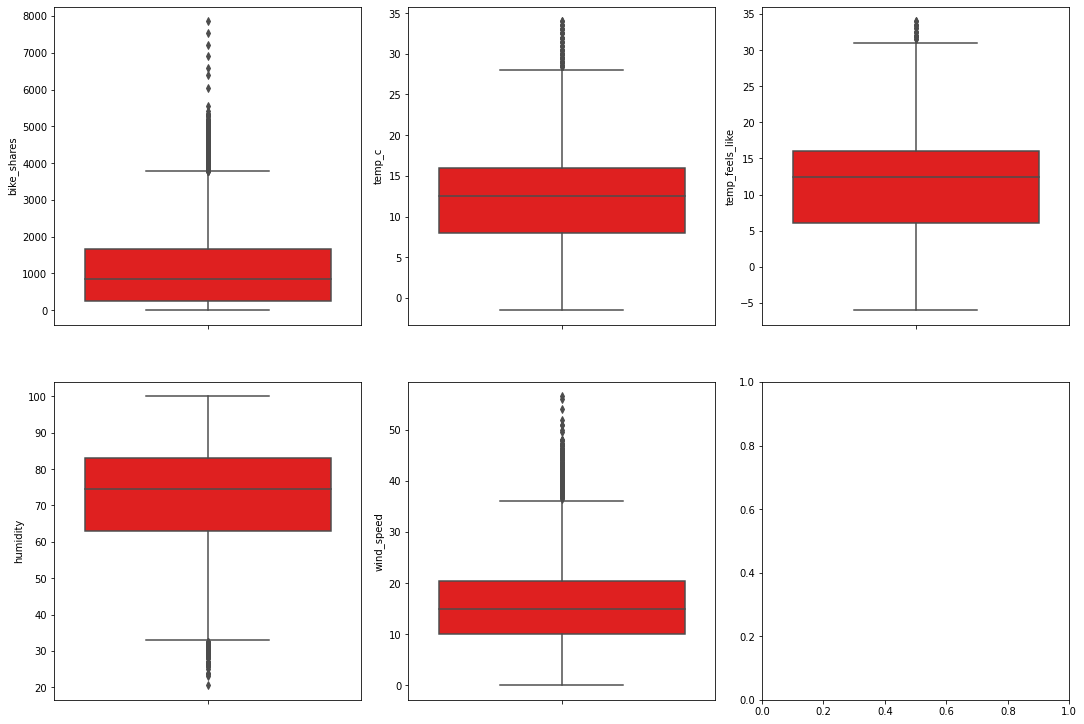

In [54]:
fig,ax=plt.subplots(2,3,figsize=(15,10))
index=0
ax=ax.flatten()
colu = ['bike_shares','temp_c','temp_feels_like','humidity','wind_speed']
for col in colu:
    sns.boxplot(y=col, data=data, color='r', ax=ax[index])
    index+=1
plt.tight_layout(pad=0.5, w_pad=1, h_pad=5.0)

## Function to detect outliers in the dataset

In [55]:
def detect_outliers(columns):
    outlier_indices = []

    for column in columns:
        # 1st quartile
        Q1 = np.percentile(data[column], 25)
        # 3st quartile
        Q3 = np.percentile(data[column], 75)
        # IQR
        IQR = Q3 - Q1
        # Outlier Step
        outlier_step = IQR * 1.5
        # detect outlier and their indeces
        outlier_list_col = data[(data[column] < Q1 - outlier_step)
                              | (data[column] > Q3 + outlier_step)].index
        # store indeces
        outlier_indices.extend(outlier_list_col)
        return outlier_indices

In [56]:
len(detect_outliers(colu))

675

## Outliers detected! 

## Now, first lets check whether the data is skwed or not, before dealing with outliers

## Function to check Skewness in data

In [57]:
def check_skweness(columnName):
    print('''Before Correcting''')
    (mu, sigma) = norm.fit(data[columnName])
    print("Mu before correcting {} : {}, Sigma before correcting {} : {}".format(
        columnName.upper(), mu, columnName.upper(), sigma))
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    sns.distplot(data[columnName], fit=norm, color="orange")
    plt.title(columnName.upper() +
              " Distplot before Skewness Correction", color="black")
    plt.subplot(1,2,2)
    stats.probplot(data[columnName], plot=plt)
    plt.show();

Before Correcting
Mu before correcting BIKE_SHARES : 1143.1016423567244, Sigma before correcting BIKE_SHARES : 1085.0769112908038


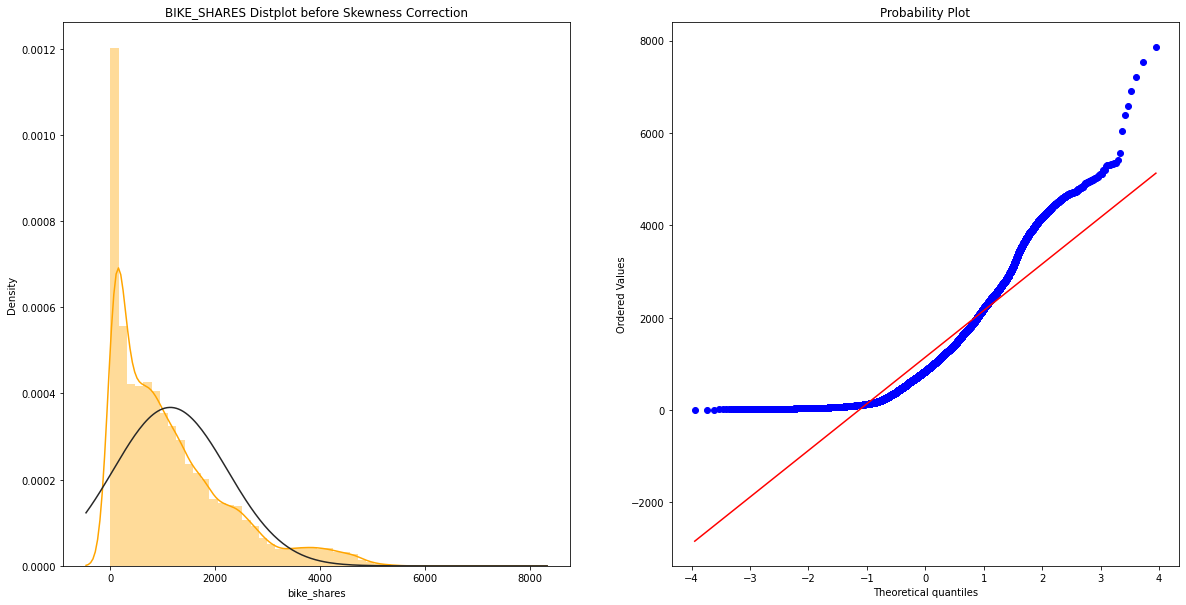

Before Correcting
Mu before correcting TEMP_C : 12.468090808162016, Sigma before correcting TEMP_C : 5.571657579643976


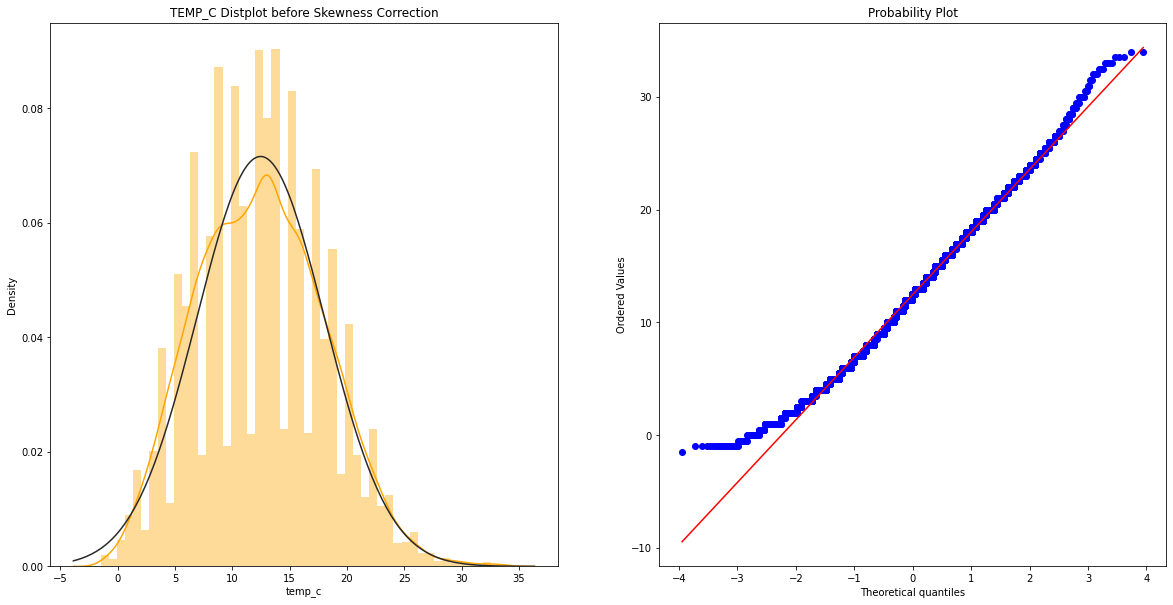

Before Correcting
Mu before correcting TEMP_FEELS_LIKE : 11.52083572604418, Sigma before correcting TEMP_FEELS_LIKE : 6.614954732860159


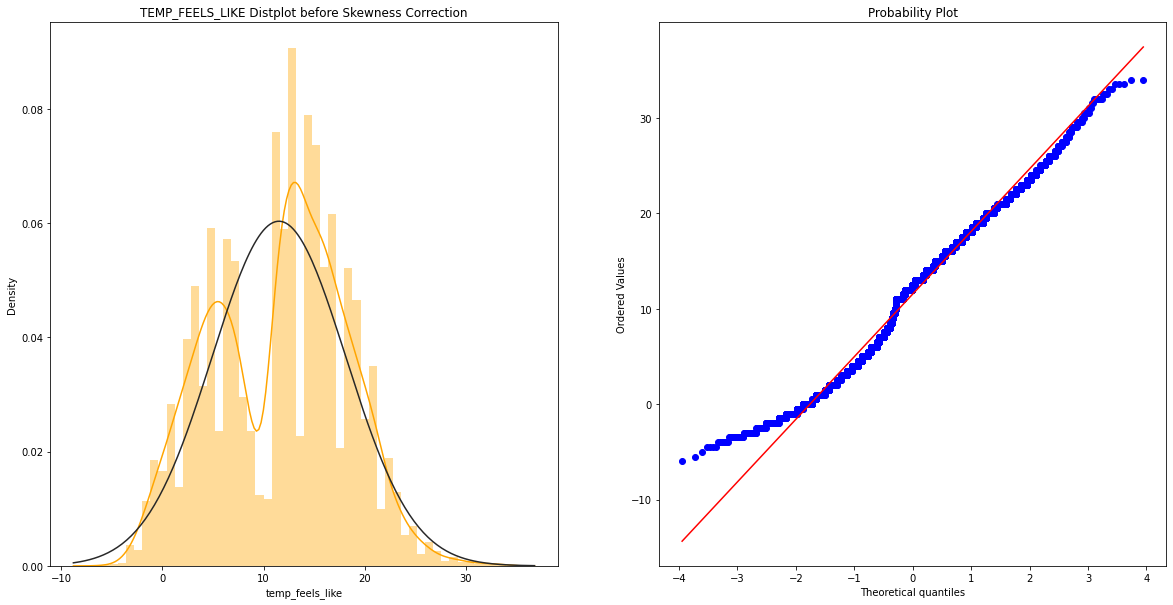

Before Correcting
Mu before correcting HUMIDITY : 72.32495405995176, Sigma before correcting HUMIDITY : 14.312775121623567


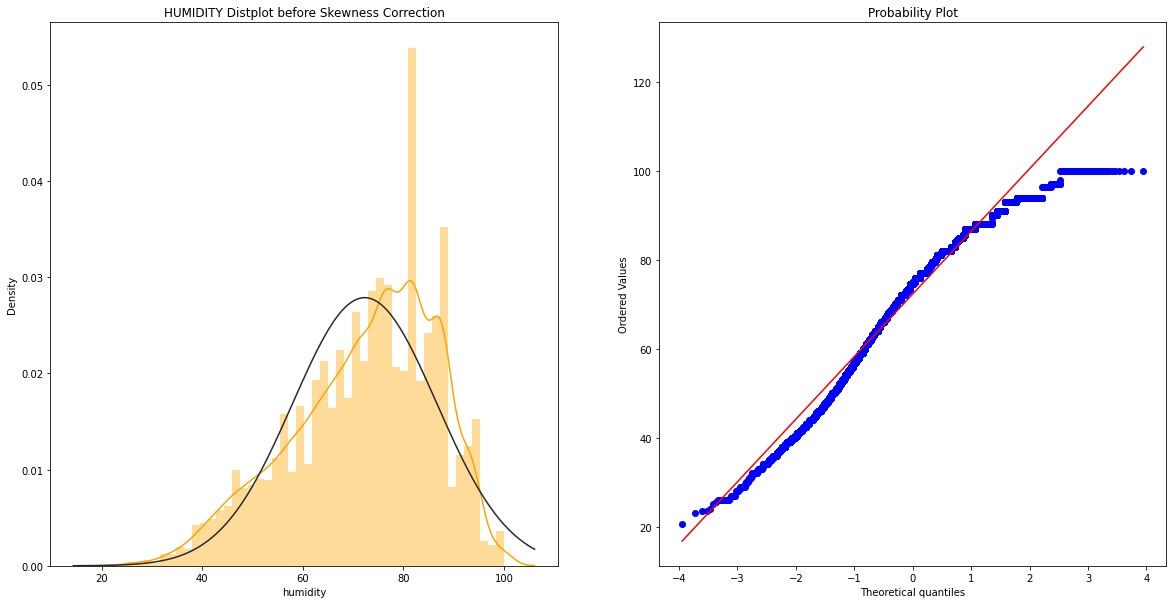

Before Correcting
Mu before correcting WIND_SPEED : 15.913063244133072, Sigma before correcting WIND_SPEED : 7.8943436530183


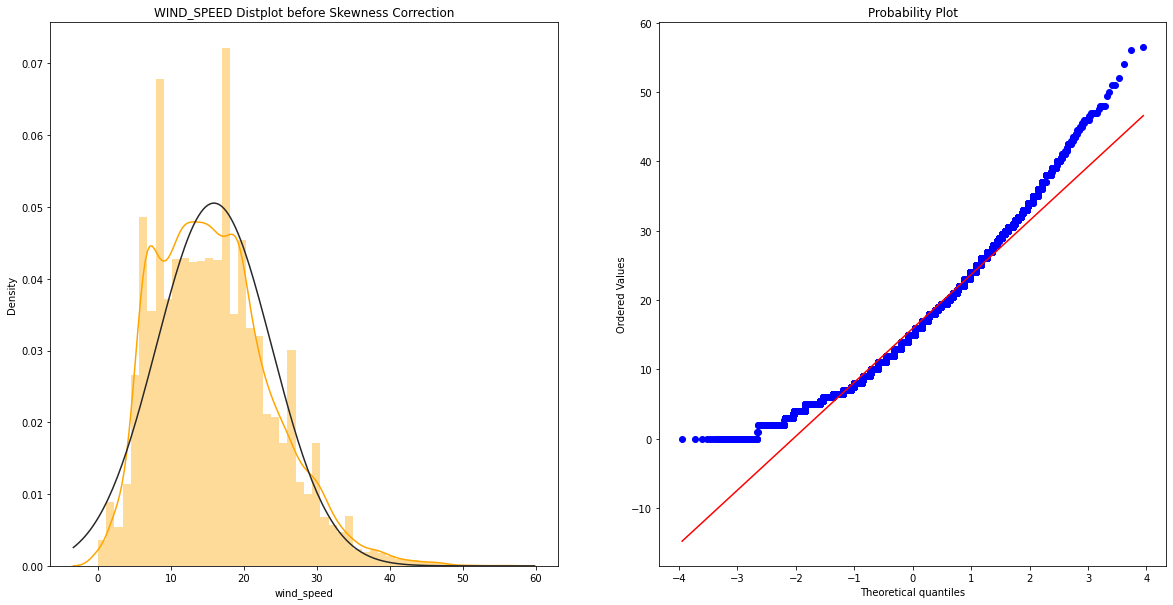

In [58]:
skewColumnList = [
    'bike_shares','temp_c','temp_feels_like','humidity','wind_speed'
]
for columns in skewColumnList:
    check_skweness(columns)

## Through these visualizations we can see that the features(bike_shares, wind_speed) look skwed whereas features(temp_c,temp_feels_like,humidity) look normally distributed

# Let's try different transformations to deal with skweness

## Function to try different transformations on features

In [59]:
def trying_different_transformations(column,transformation):
    if transformation=='boxcox':
        try:
            print("BoxCox - "+column)
            temp,temp_params = boxcox(data[column]+1)
            (mu,sigma)=norm.fit(temp)
            print("mu ",mu," sigma ",sigma)
            plt.figure(figsize=(20,10))
            plt.subplot(1,2,1)
            sns.distplot(temp, fit=norm, color="orange")
            plt.subplot(1,2,2)
            stats.probplot(temp, plot = plt)
        except ValueError:
            pass
        except ValueError:
            pass
    elif transformation=='log':
        try:
            print("Log - "+column)
            (mu,sigma)=norm.fit(np.log1p(data[column]))
            print("mu ",mu," sigma ",sigma)
            plt.figure(figsize=(20,10))
            plt.subplot(1,2,1)
            sns.distplot(np.log1p(data[column]), fit=norm, color="orange")
            plt.subplot(1,2,2)
            stats.probplot(np.log1p(data[column]), plot = plt)
        except RuntimeError:
            pass
        except ValueError:
            pass
    elif transformation=='reciprocal':
        try:
            print("Reciprocal - "+column)
            temp_r = 1/data[column]
            temp_r = temp_r.replace([np.inf, -np.inf], 0)
            (mu,sigma)=norm.fit(temp_r)
            print("mu ",mu," sigma ",sigma)
            plt.figure(figsize=(20,10))
            plt.subplot(1,2,1)
            sns.distplot(temp_r, fit=norm, color="orange")
            plt.subplot(1,2,2)
            stats.probplot(temp_r, plot = plt)
        except RuntimeError:
            pass
        except ValueError:
            pass
    elif transformation=='sqroot':
        try:
            print("Square_Root - "+column)
            (mu,sigma)=norm.fit(data[column]**(1/2))
            print("mu ",mu," sigma ",sigma)
            plt.figure(figsize=(20,10))
            plt.subplot(1,2,1)
            sns.distplot(data[column]**(1/2), fit=norm, color="orange")
            plt.subplot(1,2,2)
            stats.probplot(data[column]**(1/2), plot = plt)
        except RuntimeError:
            pass
        except ValueError:
            pass
    else:
        try:
            print("Exponential - "+column)
            (mu,sigma)=norm.fit(data[column]**(1/1.2))
            print("mu ",mu," sigma ",sigma)
            plt.figure(figsize=(20,10))
            plt.subplot(1,2,1)
            sns.distplot(data[column]**(1/1.2), fit=norm, color="orange")
            plt.subplot(1,2,2)
            stats.probplot(data[column]**(1/1.2), plot = plt)
        except RuntimeError:
            pass
        except ValueError:
            pass

## Transformations to try !

In [60]:
transformations = ['boxcox','log','reciprocal','sqroot','exp']

## Trying different transformations on bike_shares feature

BoxCox - bike_shares
mu  17.370290844281904  sigma  6.2981968583468
Log - bike_shares
mu  6.438990319008198  sigma  1.2827630480682208
Reciprocal - bike_shares
mu  0.004080760491695735  sigma  0.007220490722672692
Square_Root - bike_shares
mu  29.821847735625  sigma  15.929816068929442
Exponential - bike_shares
mu  332.2972703285766  sigma  271.25099260595084


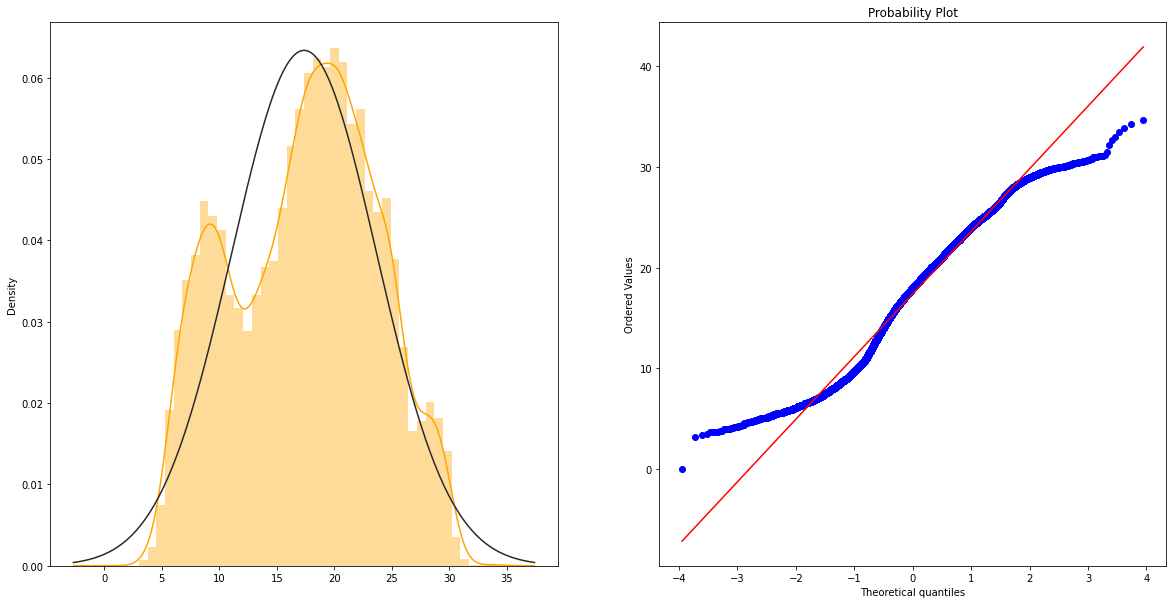

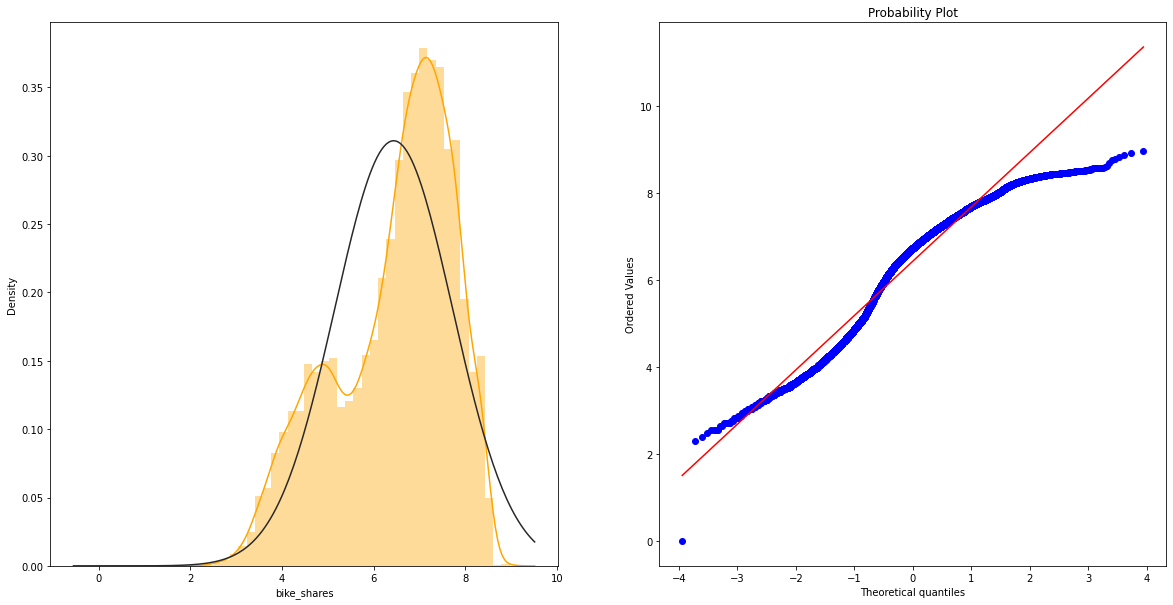

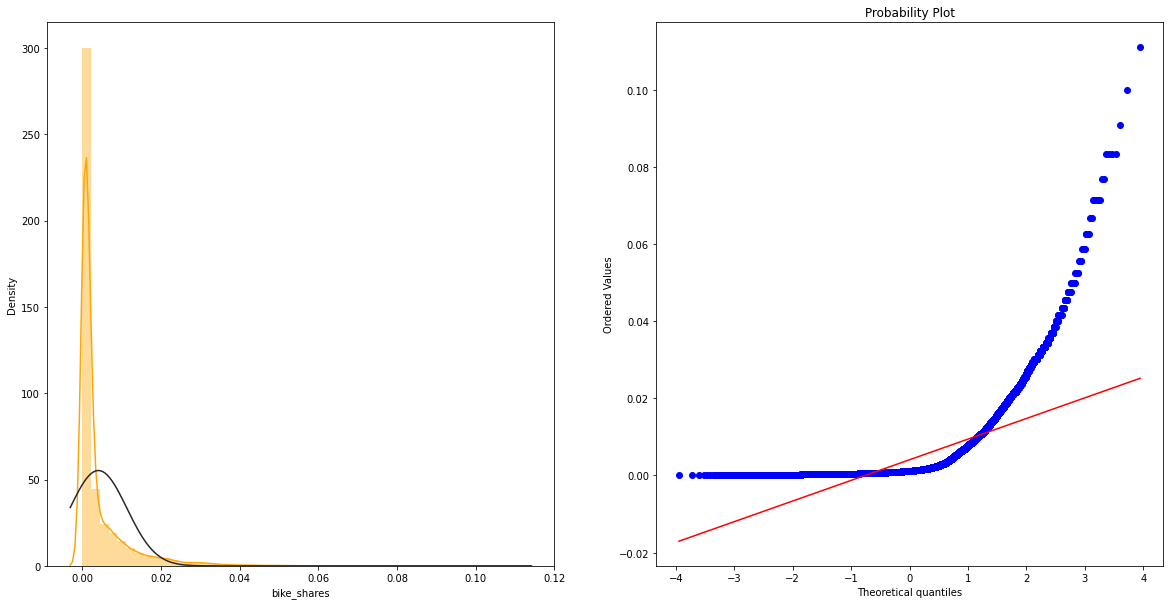

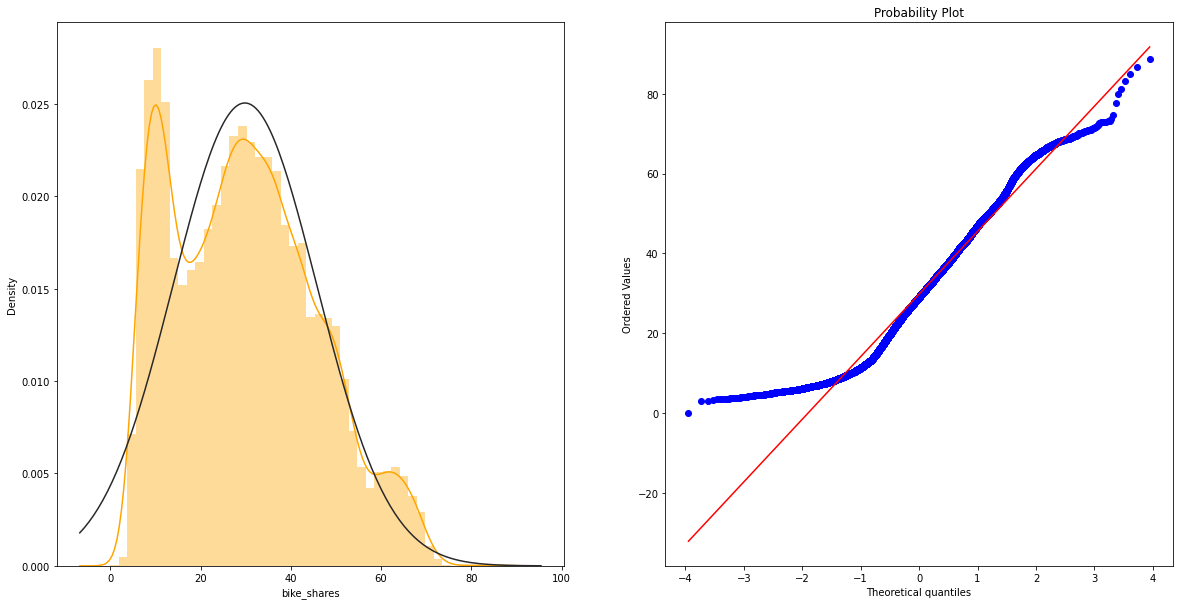

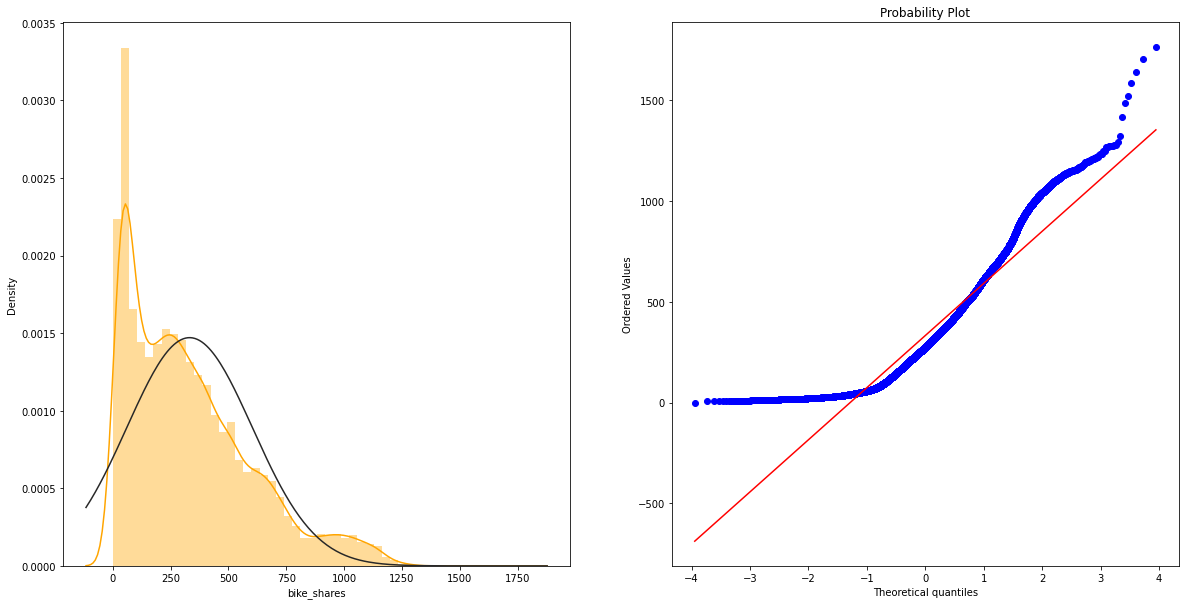

In [61]:
for x in transformations:
    trying_different_transformations('bike_shares',x)

## Trying different transformations on temp_c feature

BoxCox - temp_c
Log - temp_c
Reciprocal - temp_c
mu  0.10905896256393487  sigma  0.14658300899895504
Square_Root - temp_c
Exponential - temp_c


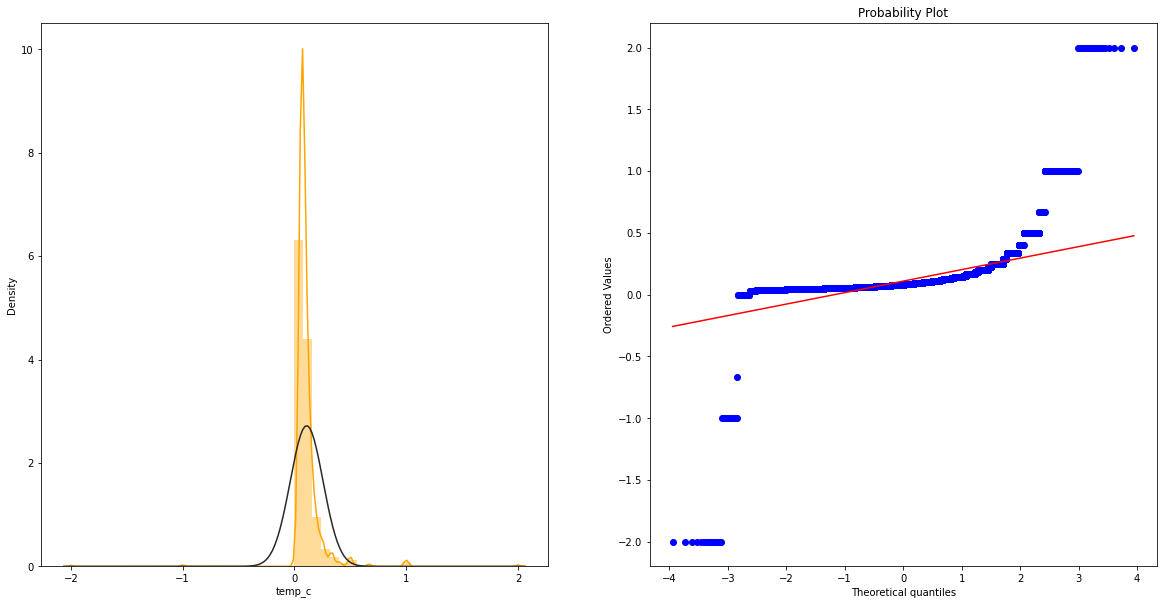

In [62]:
for x in transformations:
    trying_different_transformations('temp_c',x)

## Trying different transformations on temp_feels_like feature

BoxCox - temp_feels_like
Log - temp_feels_like
Reciprocal - temp_feels_like
mu  0.115060141597899  sigma  0.30159349207614905
Square_Root - temp_feels_like
Exponential - temp_feels_like


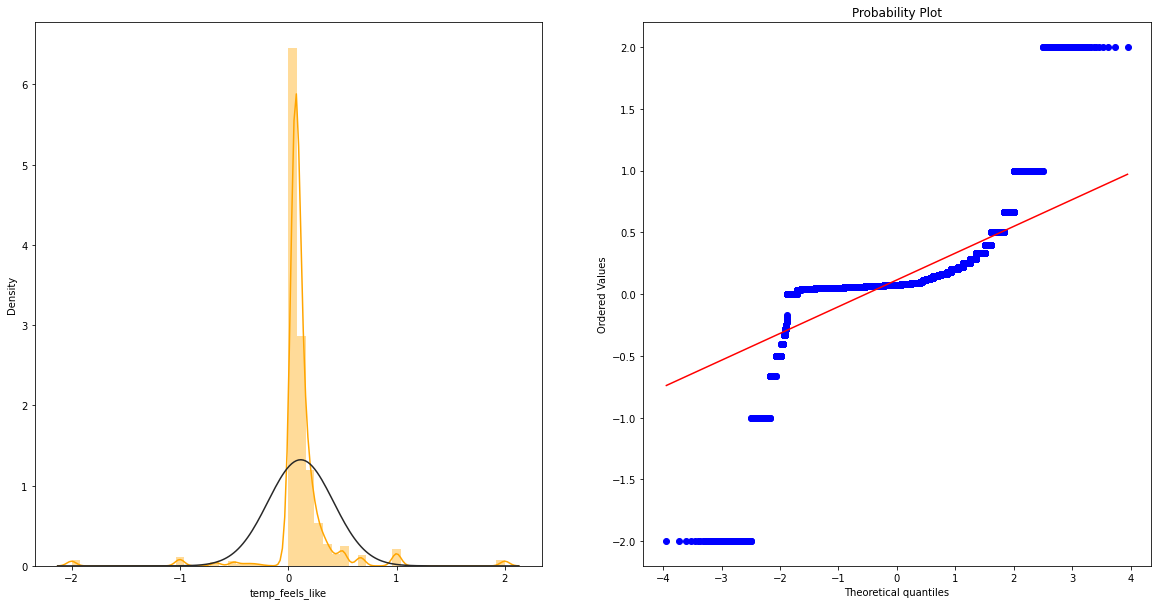

In [63]:
for x in transformations:
    trying_different_transformations('temp_feels_like',x)

## Trying different transformations on humidity feature

BoxCox - humidity
mu  3643.3843716946117  sigma  1341.3148981581041
Log - humidity
mu  4.273029612557086  sigma  0.21757954855037465
Reciprocal - humidity
mu  0.014523071248671074  sigma  0.003694010372929092
Square_Root - humidity
mu  8.458545135948325  sigma  0.8820250807526181
Exponential - humidity
mu  35.32947830258143  sigma  5.925225263033032


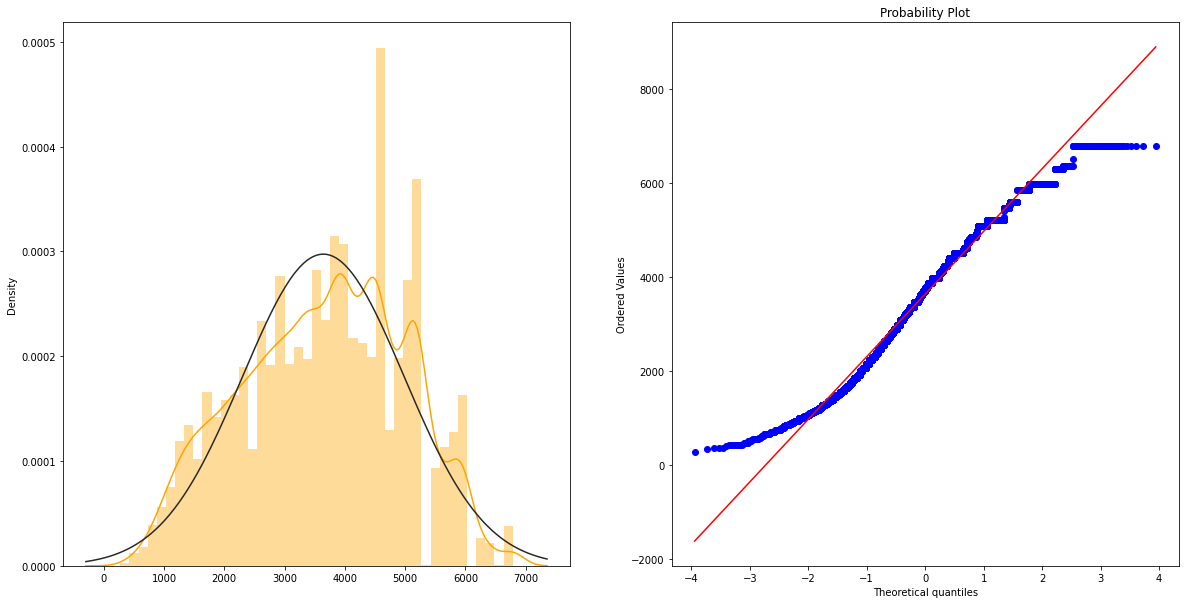

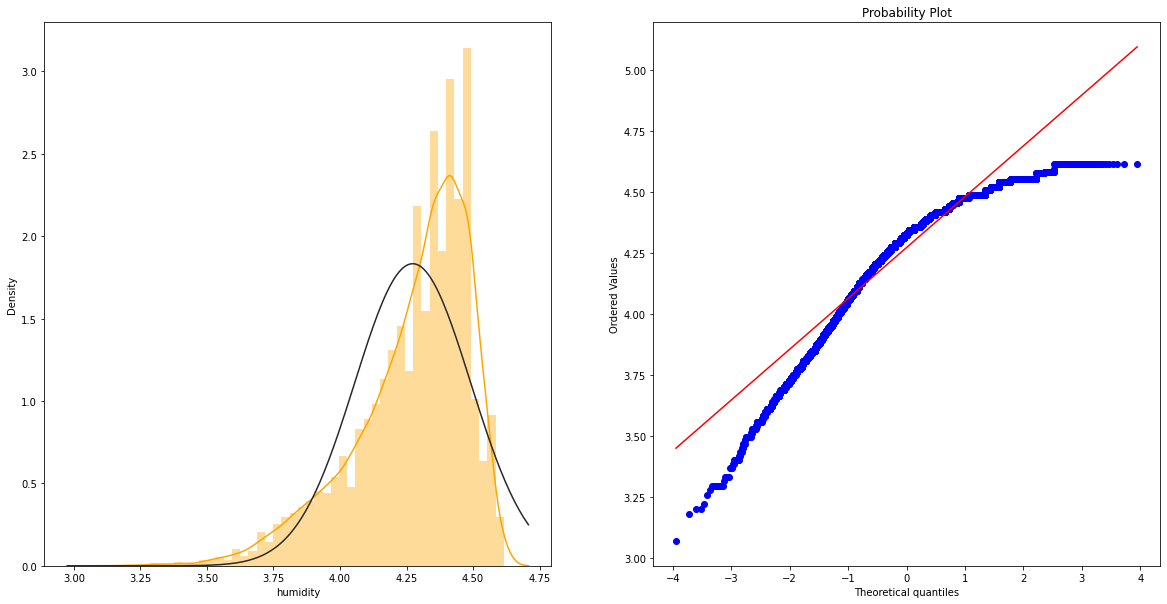

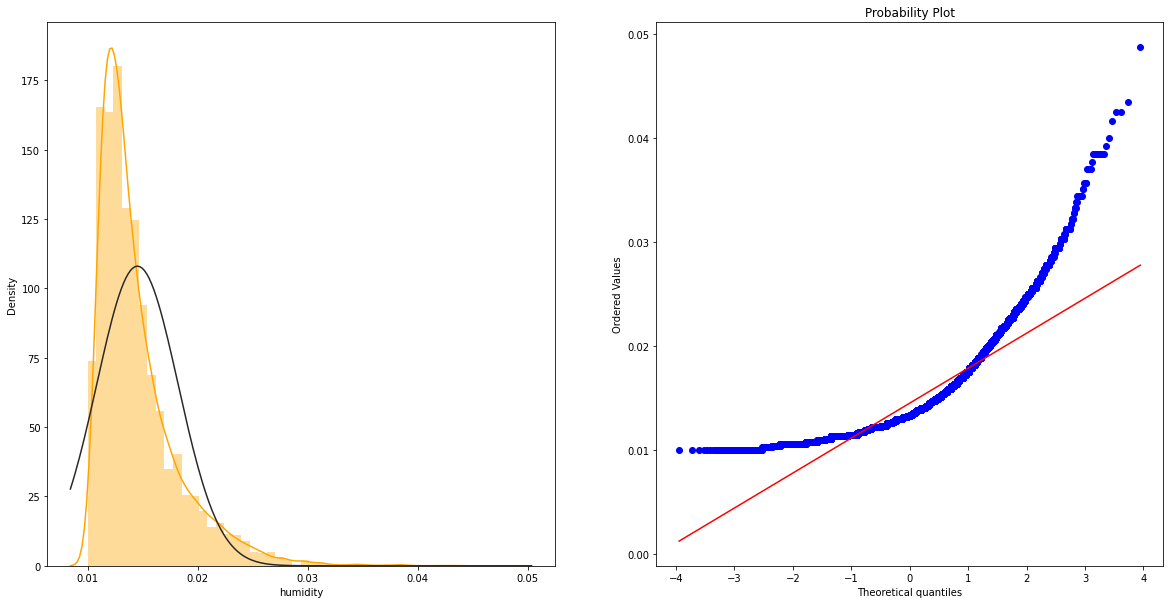

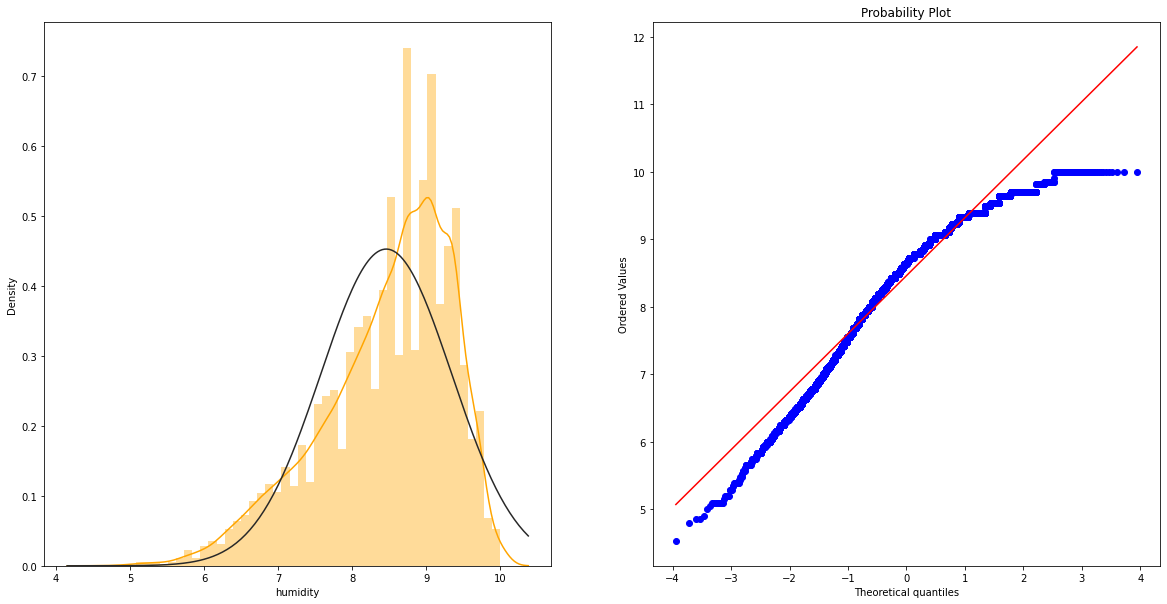

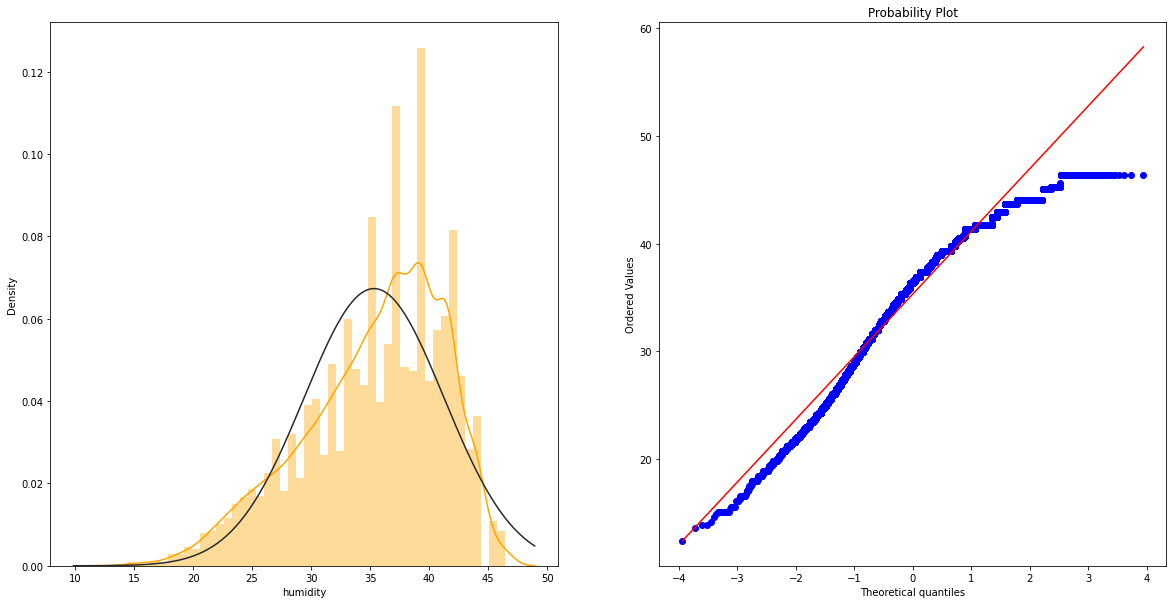

In [64]:
for x in transformations:
    trying_different_transformations('humidity',x)

## Trying different transformations on wind_speed feature

BoxCox - wind_speed
mu  5.833443446210623  sigma  1.8687913483323992
Log - wind_speed
mu  2.70478567844643  sigma  0.5319041479873212
Reciprocal - wind_speed
mu  0.08531722799212604  sigma  0.06527450683508584
Square_Root - wind_speed
mu  3.856172103900292  sigma  1.0212736896808168
Exponential - wind_speed
mu  9.857750936703049  sigma  4.136887847926391


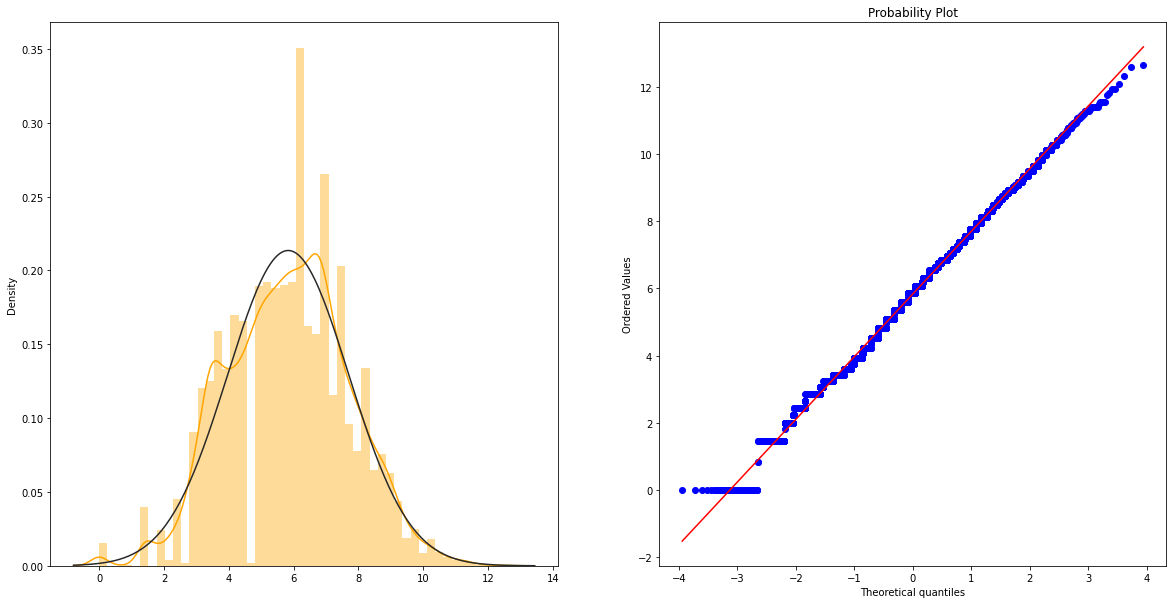

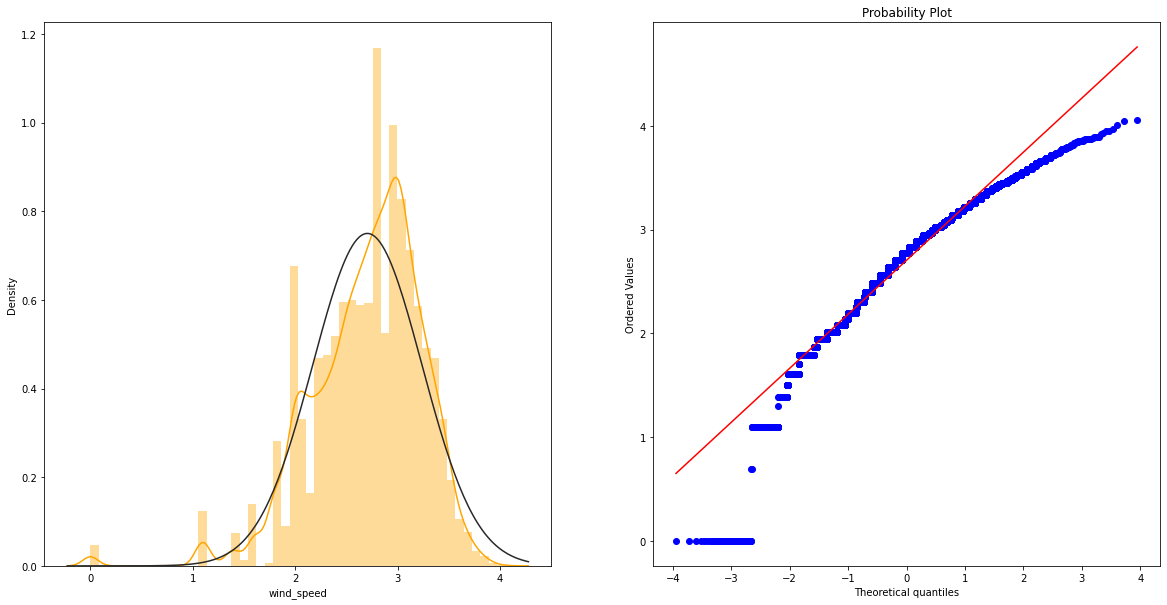

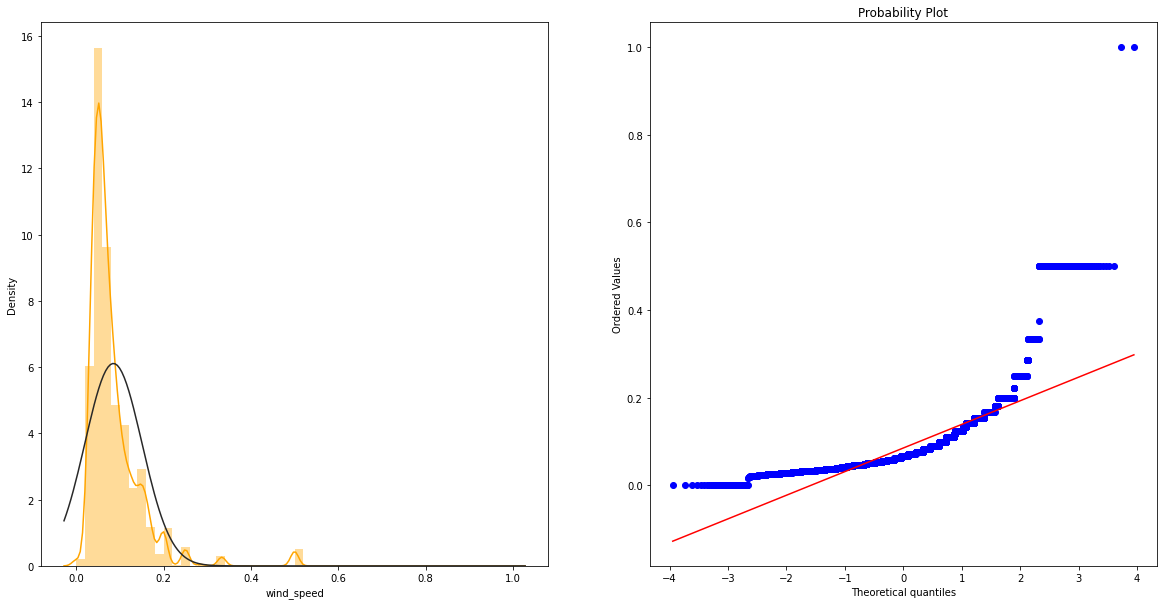

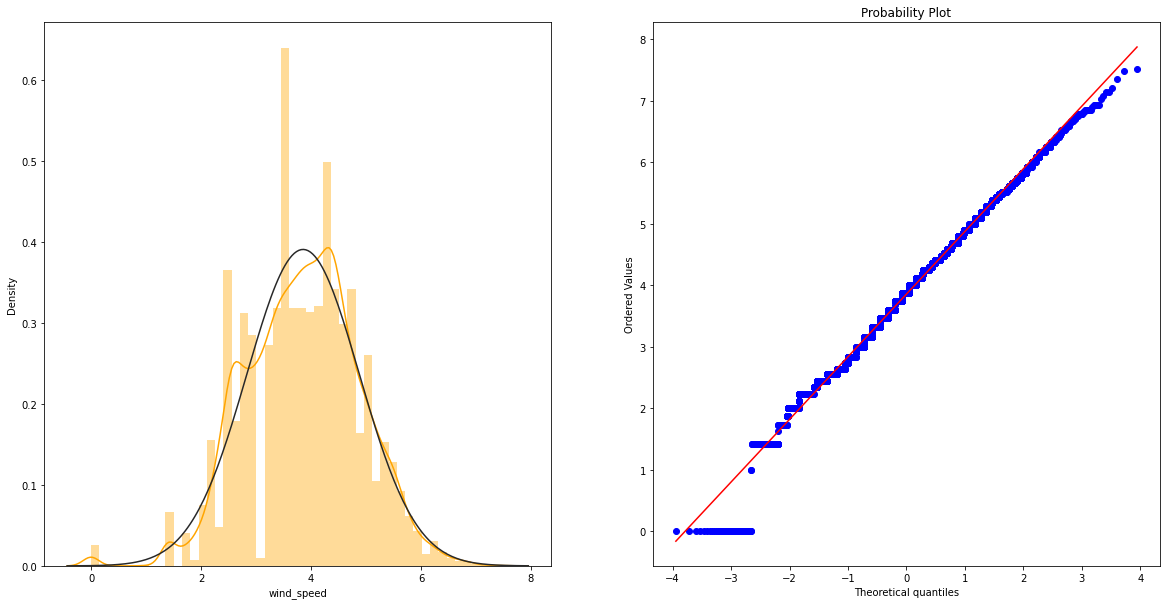

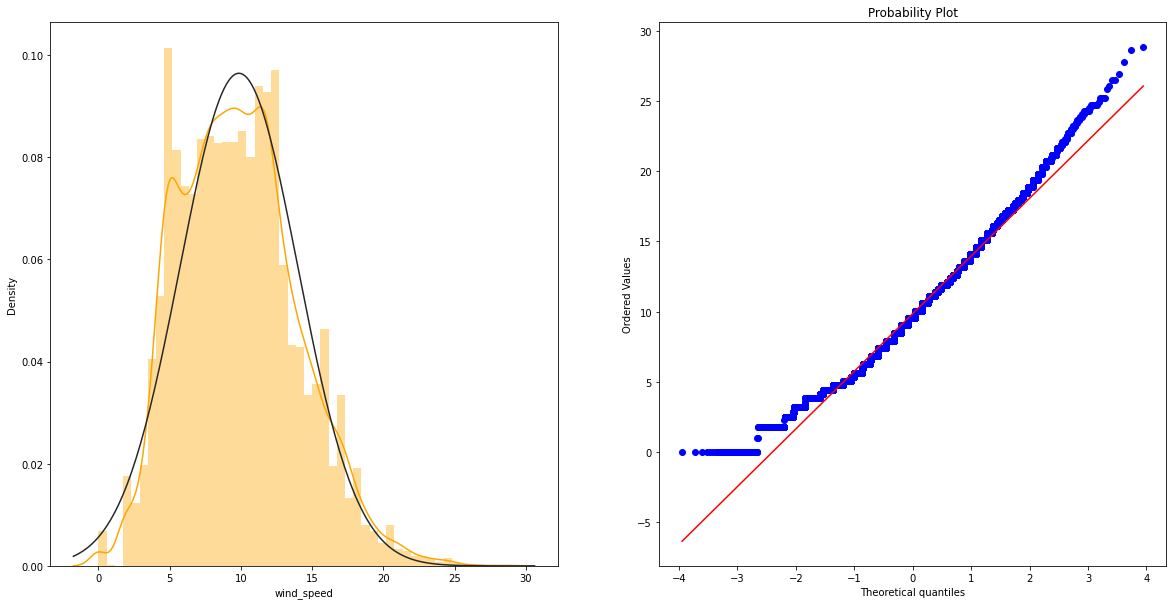

In [65]:
for x in transformations:
    trying_different_transformations('wind_speed',x)

## From the above transformations, we can see that same as we expected, features(temp_c,temp_feels_like,humidity) are already normally distributed and doesn't require transformations, whereas features(bikes_shares, wind_speed) are looking normally distributed after certain transformations

## Applying boxcox transformation

In [66]:
def skweness_correction(columnName):    
    data[columnName], temp_params = boxcox(
        data[columnName]+1)
    print('''After Correcting''')
    (mu, sigma) = norm.fit(data[columnName])
    print("Mu after correcting {} : {}, Sigma after correcting {} : {}".format(
        columnName.upper(), mu, columnName.upper(), sigma))
    plt.figure(figsize=(20, 10))
    plt.subplot(1,2,1)
    sns.distplot(data[columnName], fit=norm, color="orange")
    plt.title(columnName.upper() +
              " Distplot After Skewness Correction", color="black")
    plt.subplot(1,2,2)
    stats.probplot(data[columnName], plot = plt)
    plt.show();

After Correcting
Mu after correcting BIKE_SHARES : 17.370290844281904, Sigma after correcting BIKE_SHARES : 6.2981968583468


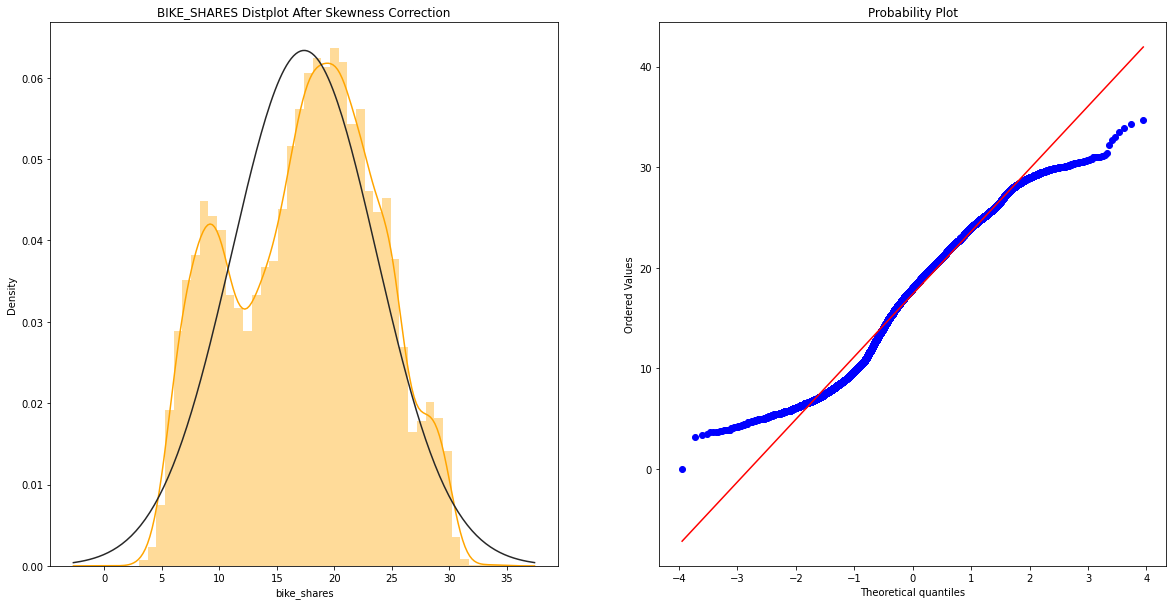

After Correcting
Mu after correcting WIND_SPEED : 5.833443446210623, Sigma after correcting WIND_SPEED : 1.8687913483323992


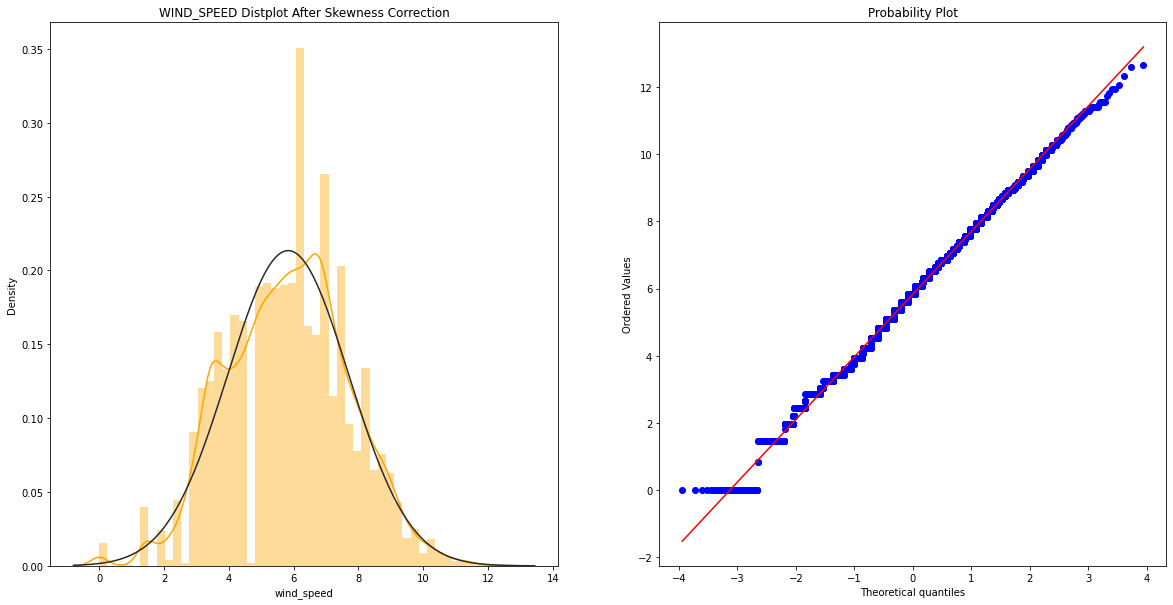

In [67]:
skewColumnList1 = [
    'bike_shares','wind_speed'
]
for columns in skewColumnList1:
    skweness_correction(columns)

## Data now normally distributed

## Now lets check outliers again

In [68]:
len(detect_outliers(colu))

0

## As we can see just by transforming features, we got outliers resolved as well, without needing to treat them seperately

In [69]:
data.head()

,timestamp,bike_shares,temp_c,temp_feels_like,humidity,wind_speed,Weather,Holiday,Weekend,Season,hour,day,day_of_week,month,year
0,2015-01-04 00:00:00,10.884991,3.0,2.0,93.0,3.236068,3.0,0.0,1.0,3.0,0,4,6,1,2015
1,2015-01-04 01:00:00,9.882018,3.0,2.5,93.0,2.854461,1.0,0.0,1.0,3.0,1,4,6,1,2015
2,2015-01-04 02:00:00,9.779602,2.5,2.5,96.5,0.000000,1.0,0.0,1.0,3.0,2,4,6,1,2015
3,2015-01-04 03:00:00,7.791138,2.0,2.0,100.0,0.000000,1.0,0.0,1.0,3.0,3,4,6,1,2015
4,2015-01-04 04:00:00,6.603341,2.0,0.0,93.0,3.416325,1.0,0.0,1.0,3.0,4,4,6,1,2015
